# Отчет по выполнению лабораторной работы в рамках оптимизации программы методом параллельных вычислений
### Черемисенов Иван Сергеевич, группа 327, ВМК МГУ, 2023г.
## Постановка задачи
Для предложенного алгоритма релаксации трехмерной матрицы необходимо модифицировать программу средствами параллельных вычислений: `OpenMP` (`for`, `task`) и `MPI`.

## Оптимизация изначальной программы
Данный мне код изначально содержал операции, которые замедляли работу программы. Я расположил индексы во вложенных циклах в порядке доступа к матрице, чтобы избежать промахов в кэше, а также заменил операции деления на константу на операцию умножения, так как она немного быстрее:
```c
for (i = 2; i <= N - 3; i++)
        for (j = 1; j <= N - 2; j++)
            for (k = 1; k <= N - 2; k++) {
                A[i][j][k] = (A[i - 1][j][k] + A[i + 1][j][k] + A[i - 2][j][k] + A[i + 2][j][k]) * 0.25f;
            }
```

## Оптимизация с помощью OpenMP for
```c
void relax() {
    for (i = 2; i <= N - 3; i++)
#pragma omp parallel for shared(A) private(k, j) num_threads(NUM_THREADS)
            for (j = 1; j <= N - 2; j++)
                for (k = 1; k <= N - 2; k++) {
                    A[i][j][k] = (A[i - 1][j][k] + A[i + 1][j][k] + A[i - 2][j][k] + A[i + 2][j][k]) * 0.25;
                }

    for (j = 2; j <= N - 3; j++)
#pragma omp parallel for shared(A) private(i, k) num_threads(NUM_THREADS)
            for (i = 1; i <= N - 2; i++)
                for (k = 1; k <= N - 2; k++) {
                    A[i][j][k] = (A[i][j - 1][k] + A[i][j + 1][k] + A[i][j - 2][k] + A[i][j + 2][k]) * 0.25;
                }

    for (k = 2; k <= N - 3; k++)
#pragma omp parallel for shared(A) private(i, j) reduction(max:eps) num_threads(NUM_THREADS)
            for (i = 1; i <= N - 2; i++)
                for (j = 1; j <= N - 2; j++) {
                    float e;
                    e = A[i][j][k];
                    A[i][j][k] = (A[i][j][k - 1] + A[i][j][k + 1] + A[i][j][k - 2] + A[i][j][k + 2]) * 0.25;
                    eps = Max(eps, fabs(e - A[i][j][k]));
                }

}
```

Изменения:
1. Я изменил расстановку индексов так, чтобы первым стоял тот, по которому важно отсутствие гонки по данным.
2. Добавил директивы omp for с указанием матрицы как shared и приватными остальные два индекса, а также указал количество потоков, в котором будет исполняться код.
3. Для последнего цикла, в котором считается eps, я добавил опцию reduce по принципу max для корректного вычисления eps в нескольких потоках

Я провел тестирование на суперкомпьютере Polus c разными параметрами размера матрицы, уровня оптимизации компилятора и количества потоков:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import *

def draw_3d_barplot(x, y, dz, plot_name, cnt):
    plt.rcParams["figure.figsize"] = [20, 20]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    clr = ['r', 'g', 'b', 'y', 'purple']

    z = np.zeros(len(x))
    dx = np.empty(len(x))
    dx.fill(2)
    dy = np.empty(len(x))
    dy.fill(0.05)

    # Plotting 3D bars
    ax.bar3d(x, y, z, dx, dy, dz, color=clr[cnt % 5])
    
    plt.title(plot_name, fontsize=20)
    plt.yticks(range(0, 5), ["MINI_DATASET", "SMALL_DATASET", "MEDIUM_DATASET", "LARGE_DATASET", "EXTRALARGE_DATASET"])
    ax.set_xlabel('Number of threads', fontsize=13)
    ax.set_ylabel('Dataset size', fontsize=13, labelpad=20)
    ax.set_zlabel('Execution time', fontsize=13)
    plt.show()


In [39]:
num_threads = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40, 60, 80, 100, 120, 140, 160]
datasets = {
    "MINI_DATASET": 0,
    "SMALL_DATASET": 1,
    "MEDIUM_DATASET": 2,
    "LARGE_DATASET": 3,
    "EXTRALARGE_DATASET": 4
}

def display_stats(file, name):   
    opt_dict = {
        "0": list(),
        "1": list(),
        "2": list(),
        "3": list(),
        "fast": list()
    }
    
    with open(file) as data:
        for line in data.read().splitlines():
            line = line.split(' ')
            opt_dict[line[2]].append([line[1], line[3], line[4]])
    
    for opt in opt_dict.keys():
        if not opt_dict[opt]:
            continue
        x_data = list()
        y_data = list()
        z_data = list()
        
        for line in opt_dict[opt]:
            x_data.append(int(line[1]))
            y_data.append(datasets[line[0]])
            z_data.append(float(line[2]))

        draw_3d_barplot(x_data, y_data, z_data, f'{name} - Optimization level O{opt}', 1)


C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


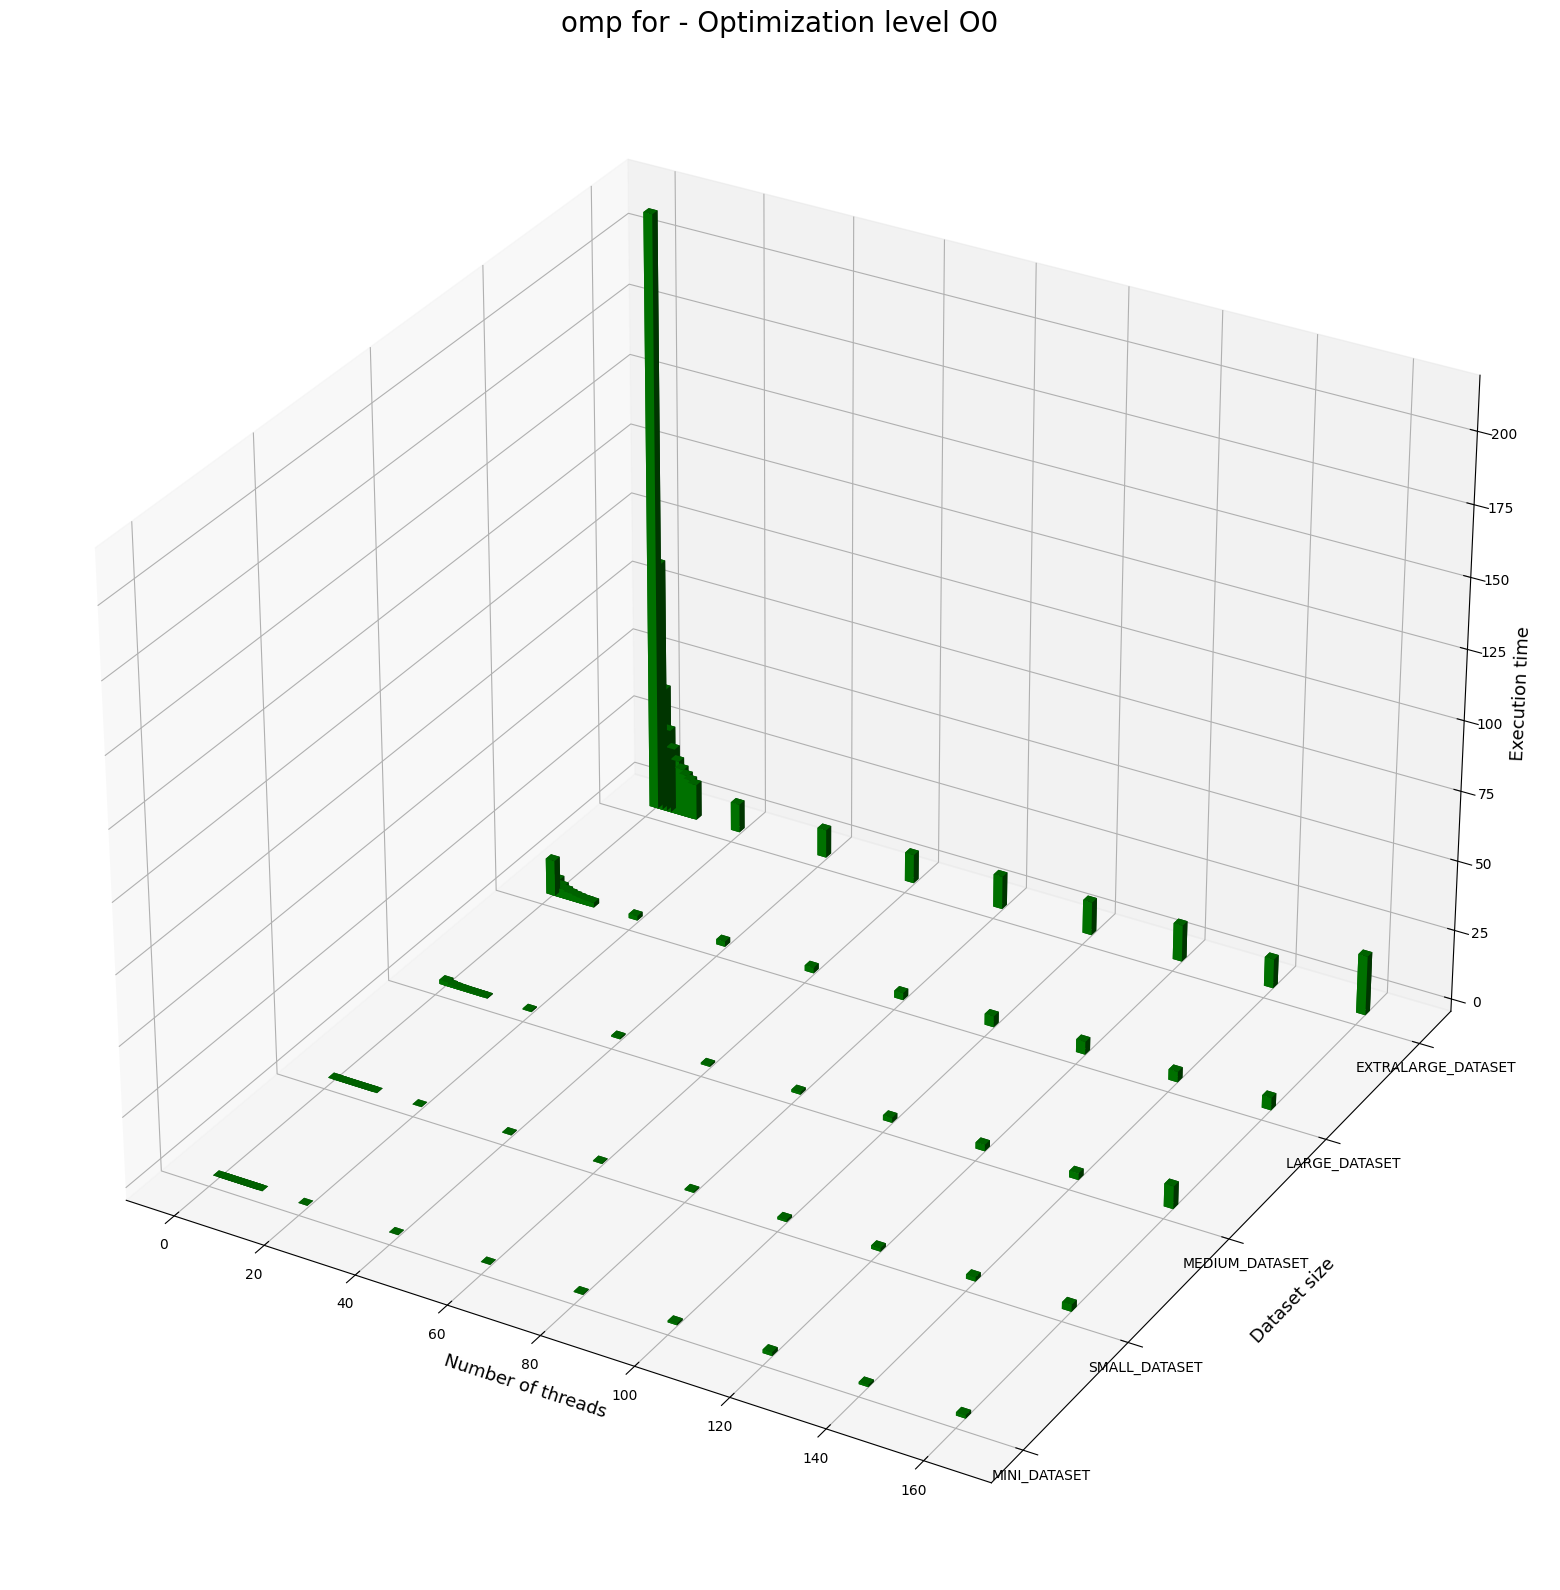

C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


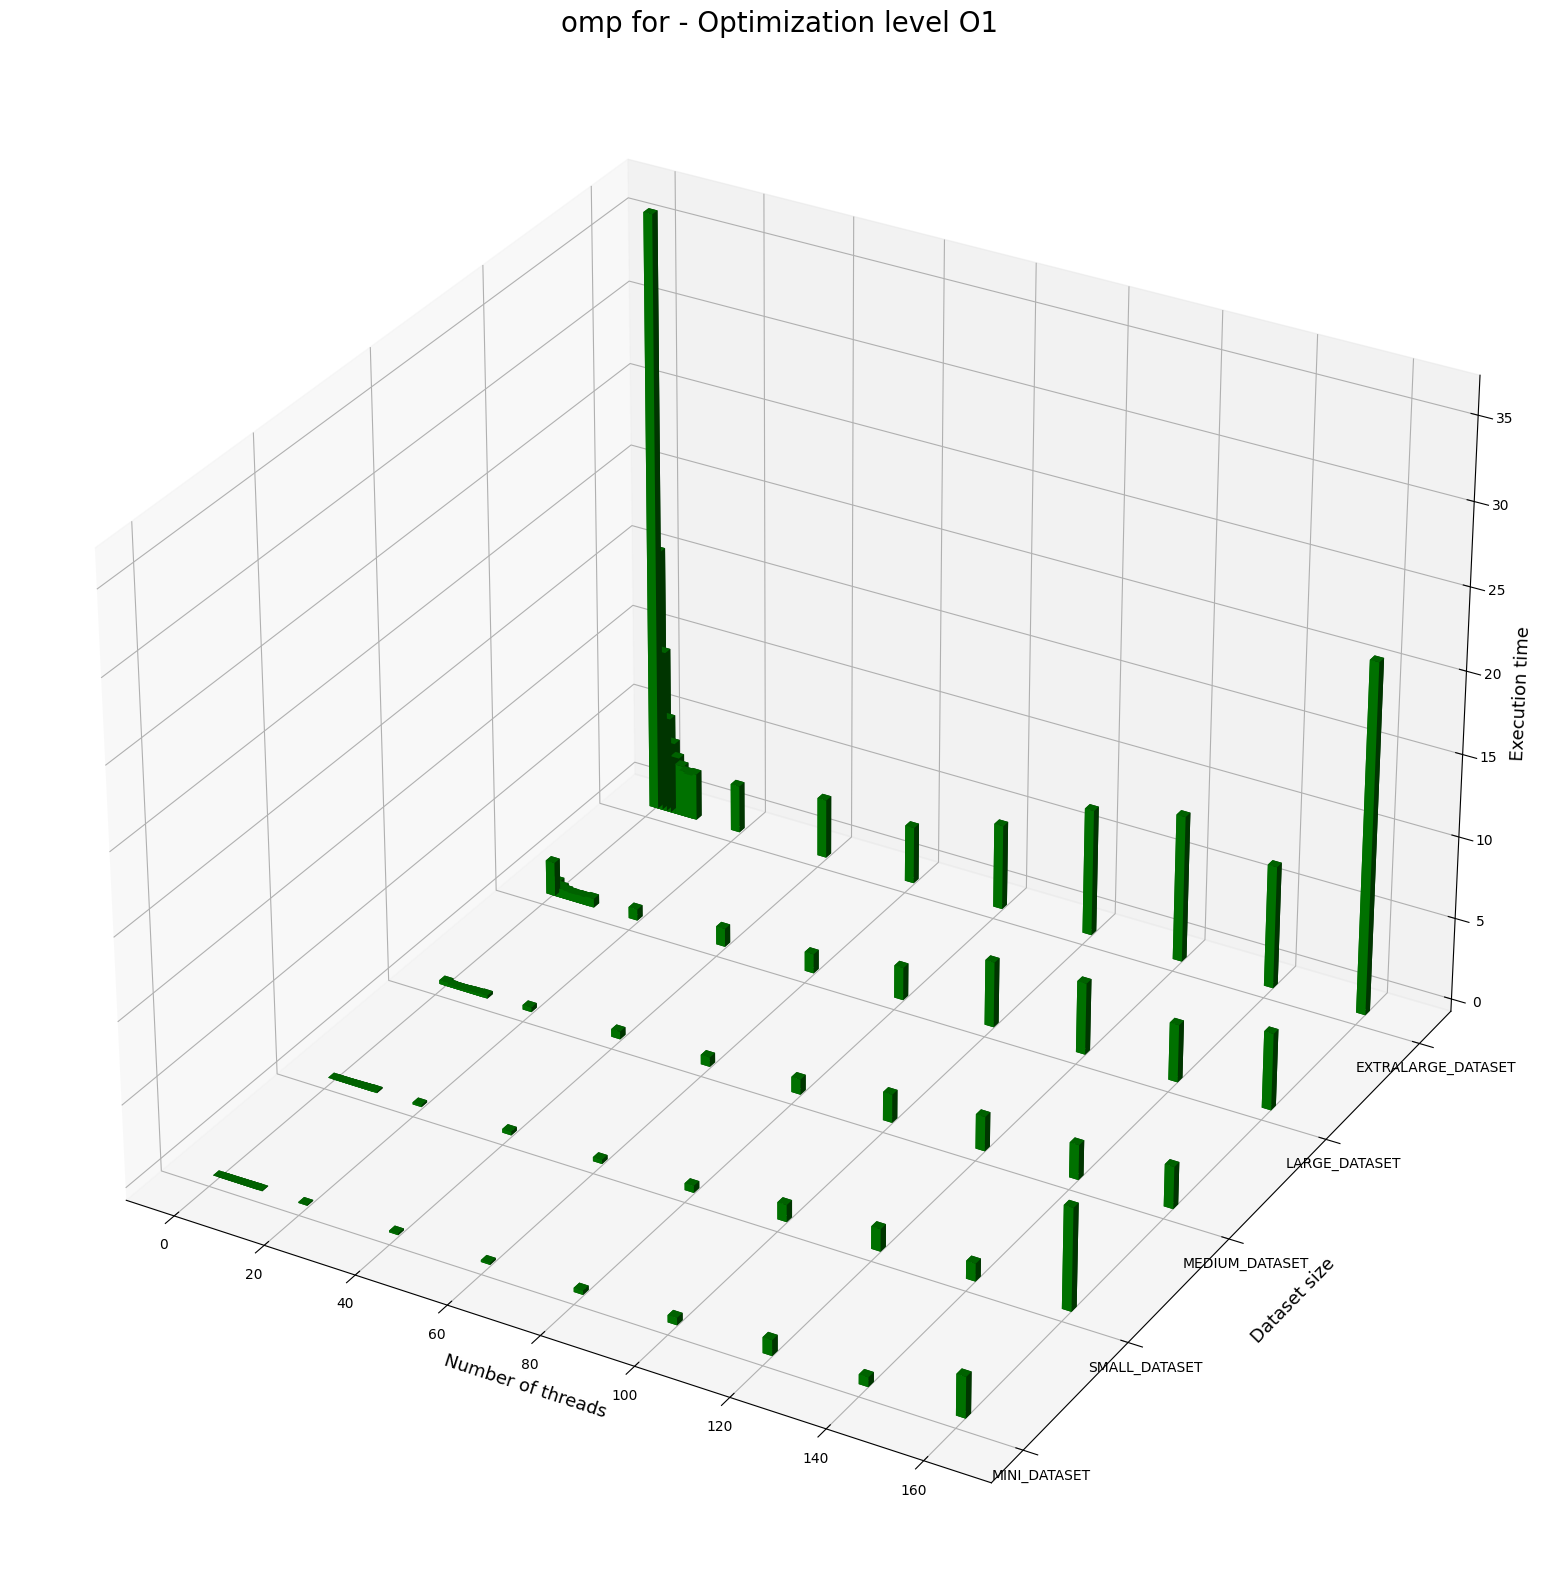

C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


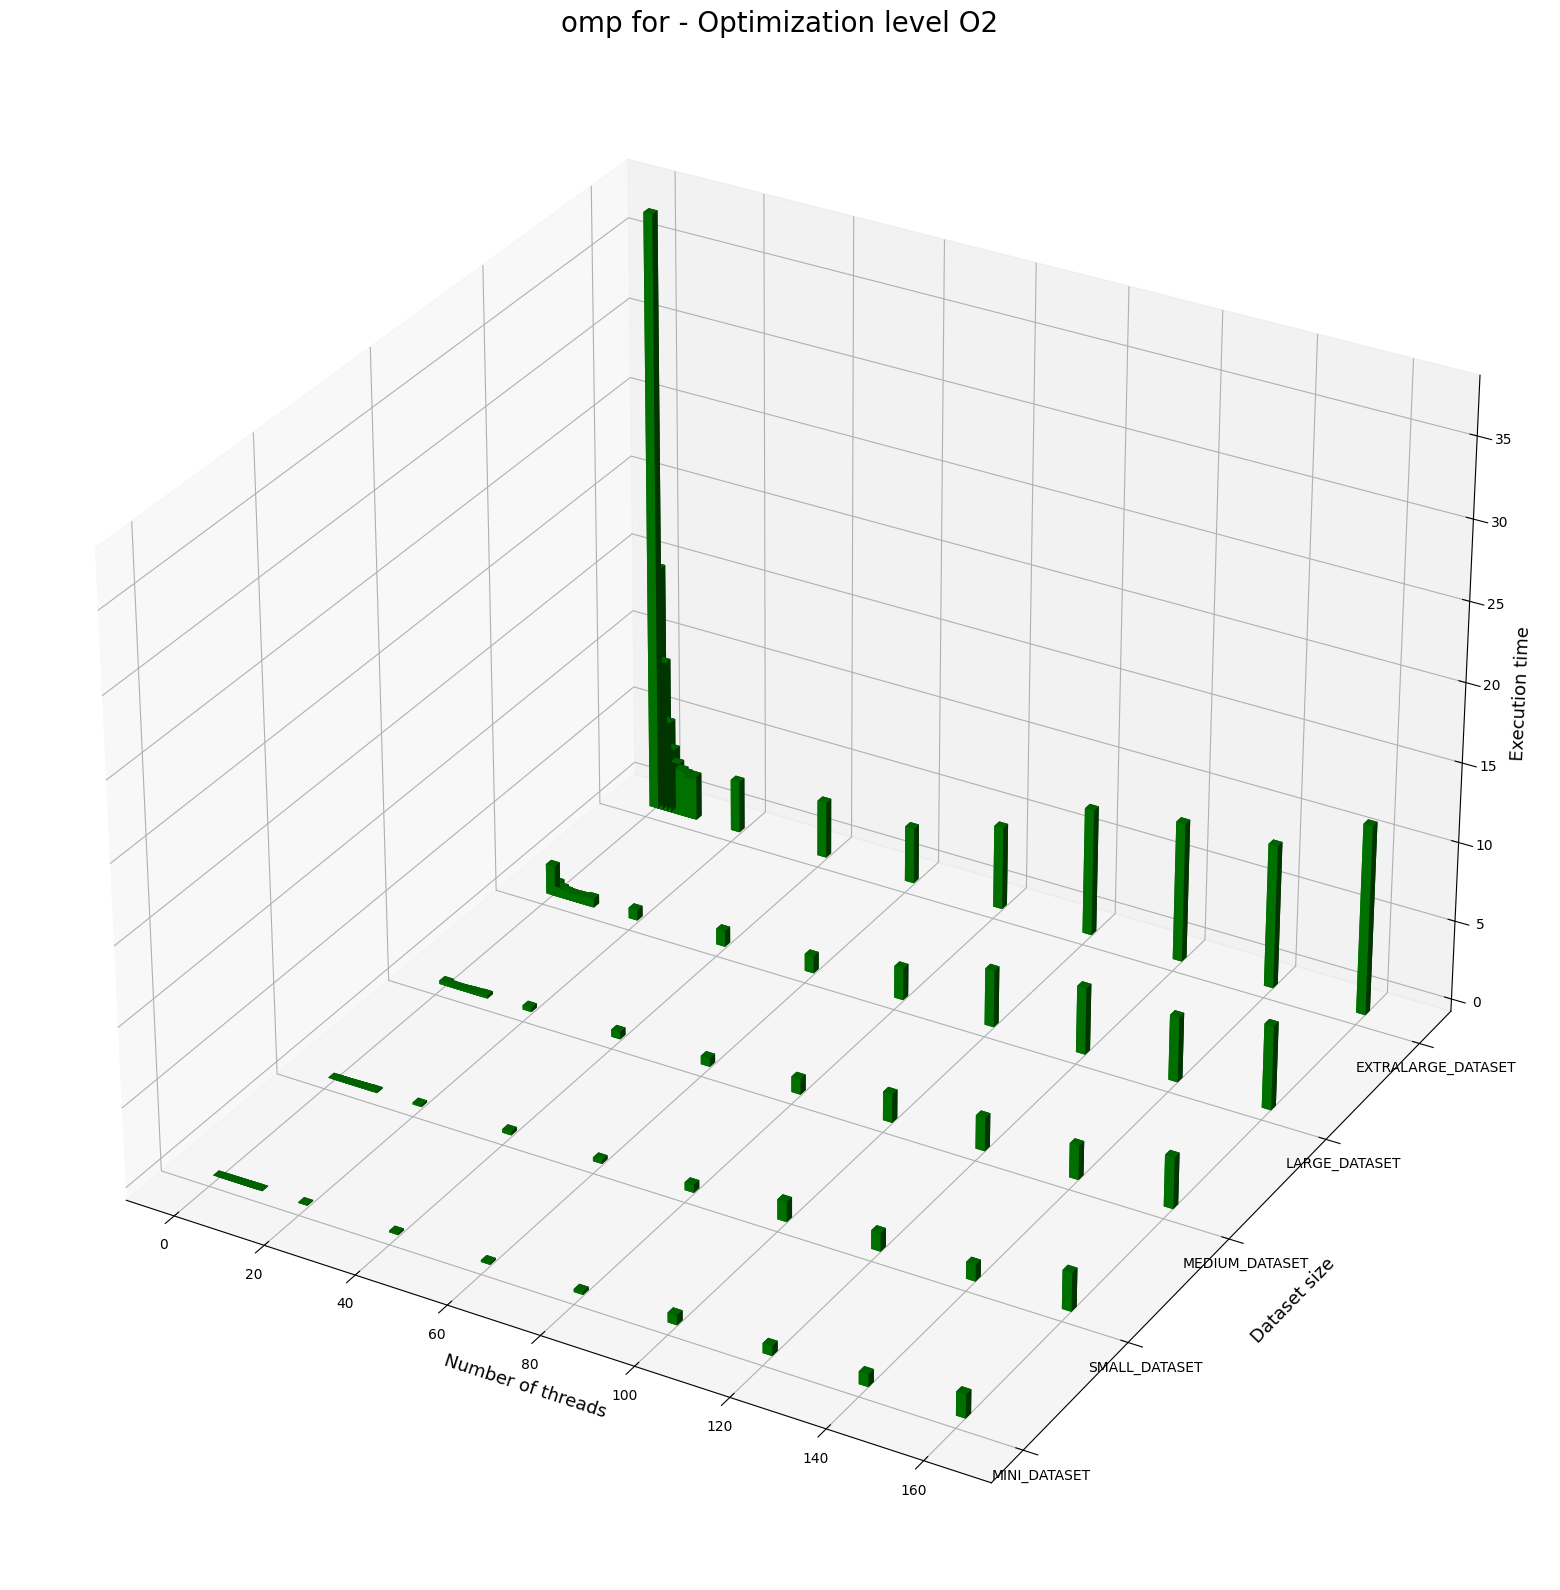

C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


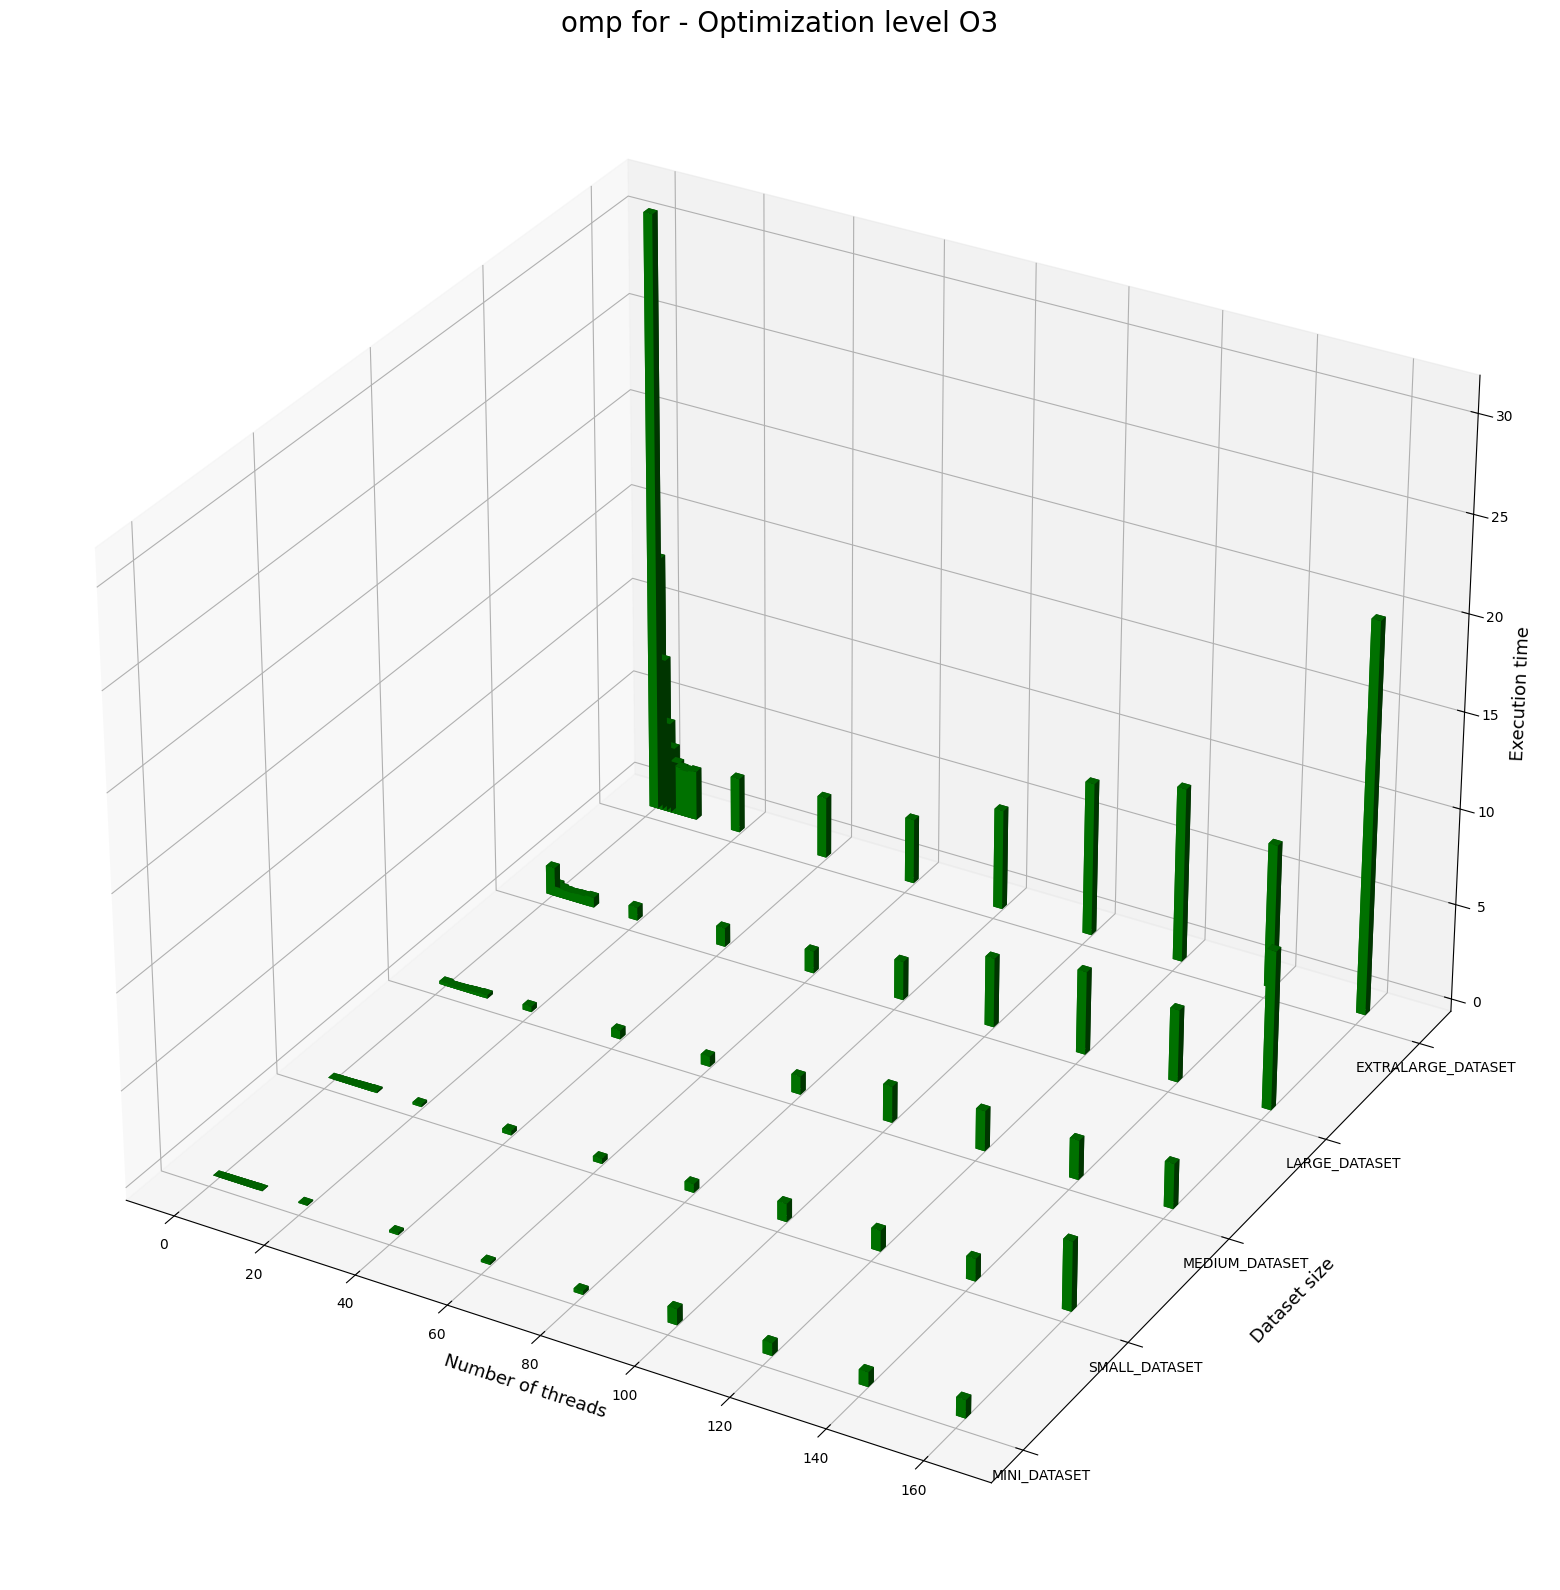

C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


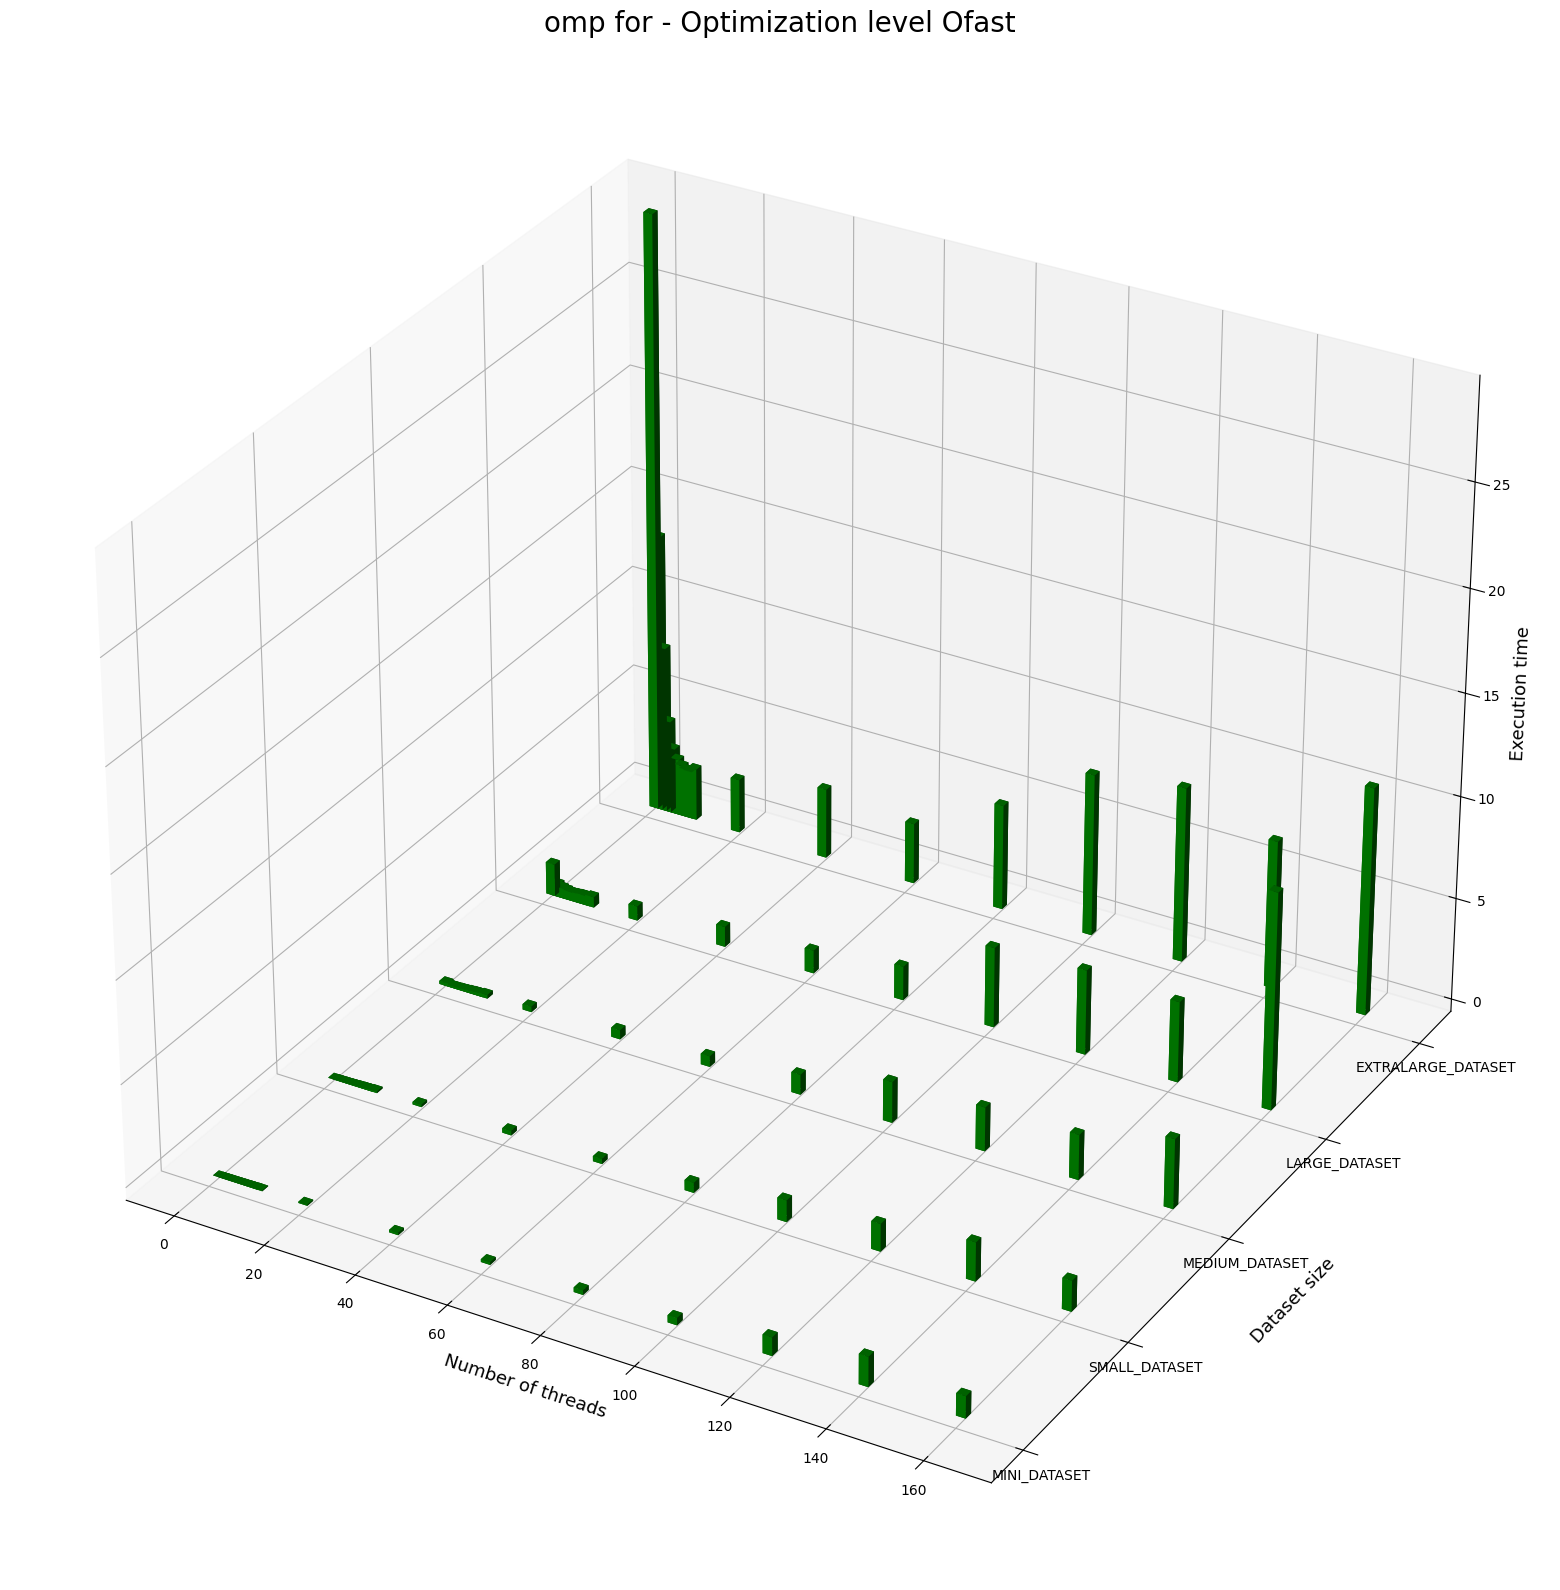

In [40]:
display_stats('for.txt', 'omp for')

В ходе анализа полученных данных можно заметить, что оптимизация компилятором сильно влияет на результат по времени. Также видно, что время достигает минимума примерно на 40 потоках, после этого происходит рост времени исполнения. 

## Оптимизация с помощью OpenMP task
Для распределения по таскам изначально я задумал сделать создание таска на каждой итерации цикла, однако это показало плохие результаты на вычислителе. Я предположил, что это связано с тем, что тасков создавалось слишком много (в некоторых случаях 1024) для заданного числа потоков, поэтому разработал разбиения вычисляемого пространства на блоки, количество которых может быть равно или кратно количеству потоков.

```c
	const int task_batch_size = N / TASKS_COUNT + 1;
	for (task_offset = 1; task_offset < N - 1; task_offset += task_batch_size){
		int task_end = task_offset + task_batch_size;
		if (task_end > N - 1)
			task_end = N - 1;

#pragma omp task shared(A) firstprivate(i, j, k, task_offset)
		for (k = task_offset; k < task_end; k++) {
			for (i = 2; i <= N - 3; i++) {
				for (j = 1; j <= N - 2; j++) {
					A[i][j][k] = (A[i - 1][j][k] + A[i + 1][j][k] + A[i - 2][j][k] + A[i + 2][j][k]) * 0.25f;
				}
			}
		}
	}
#pragma omp taskwait
```

Посмотрим на результаты выполнения на Полюсе:

C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


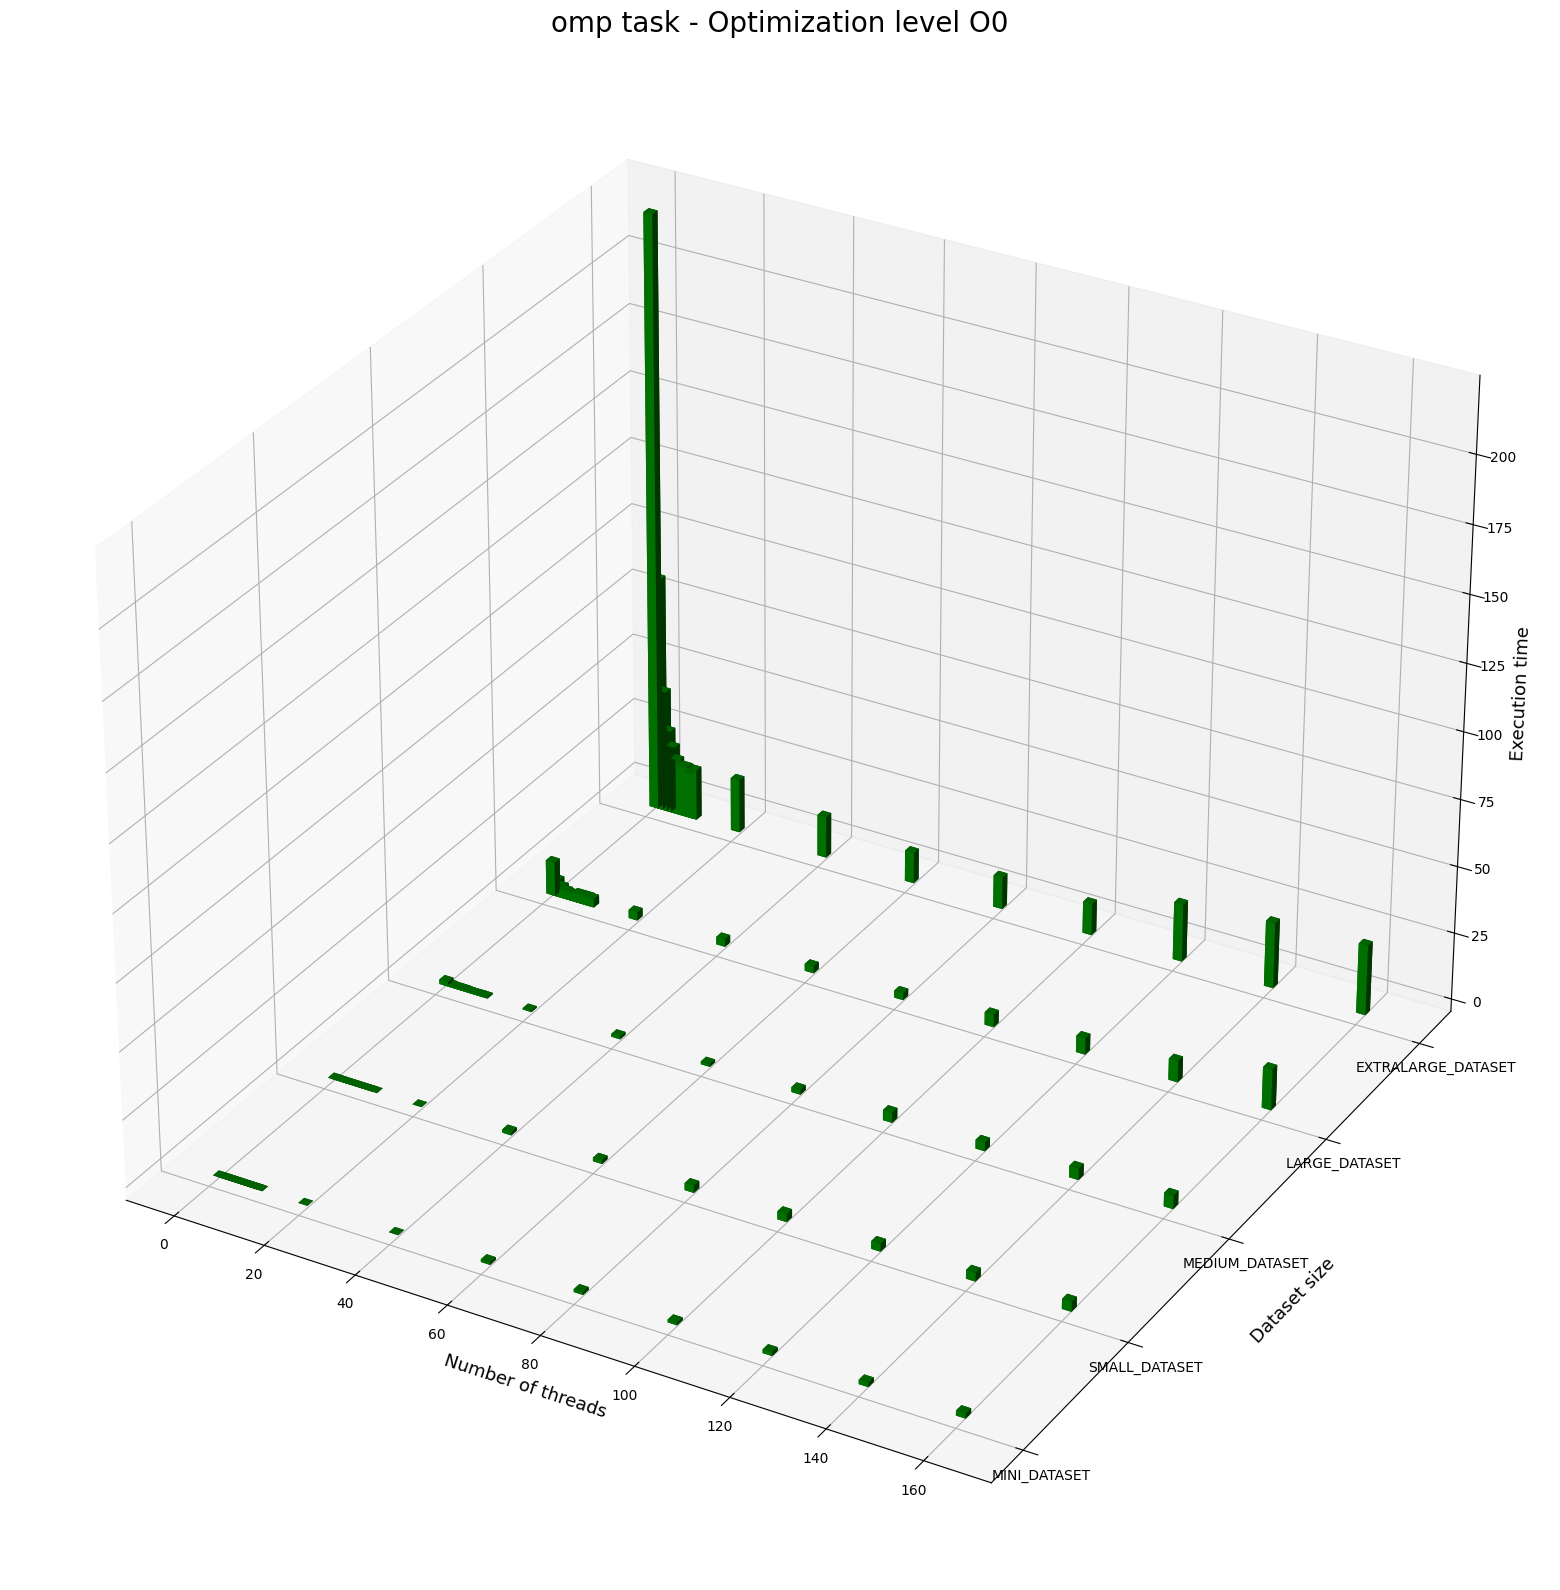

C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


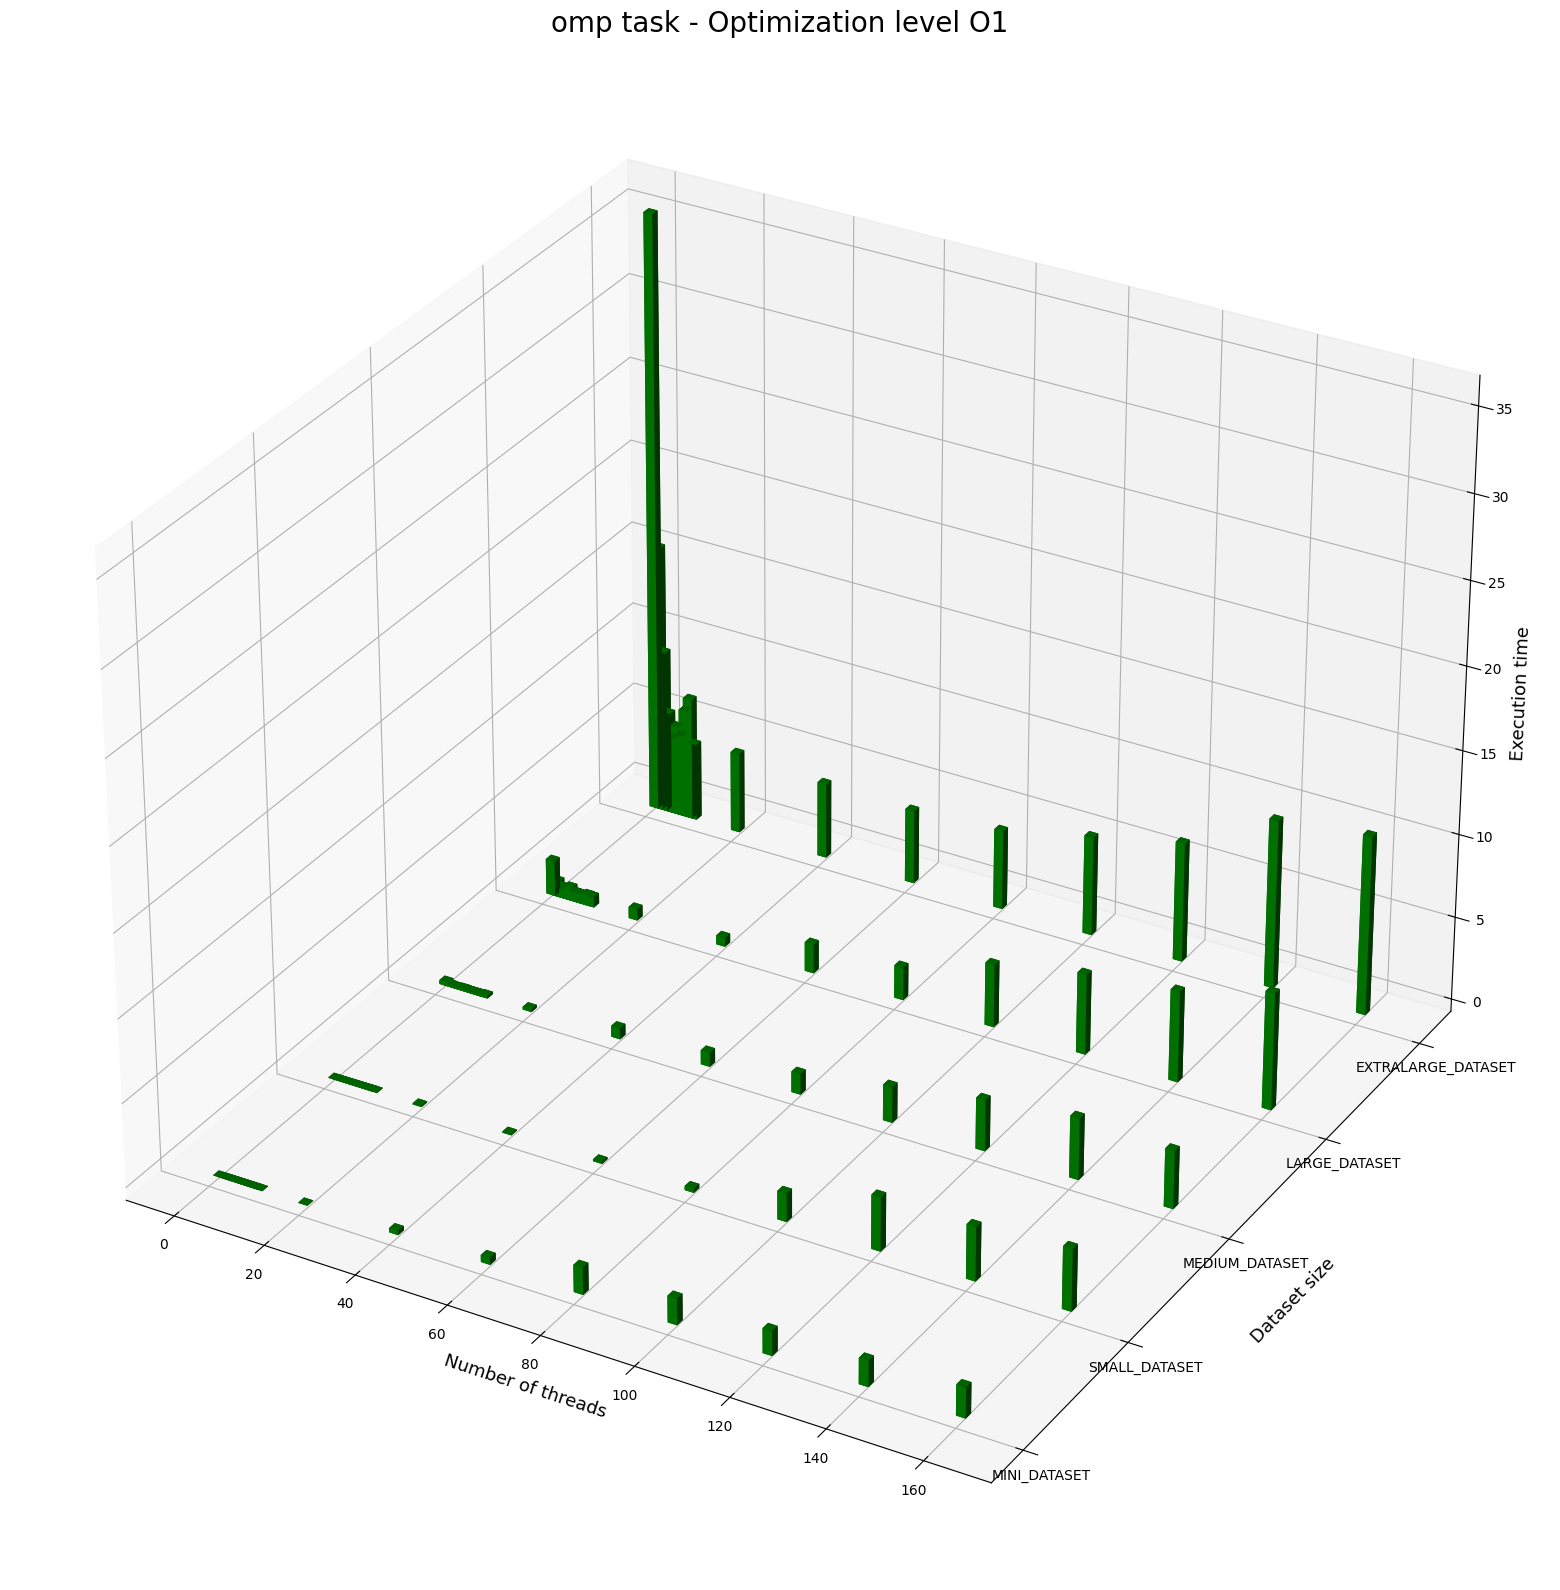

C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


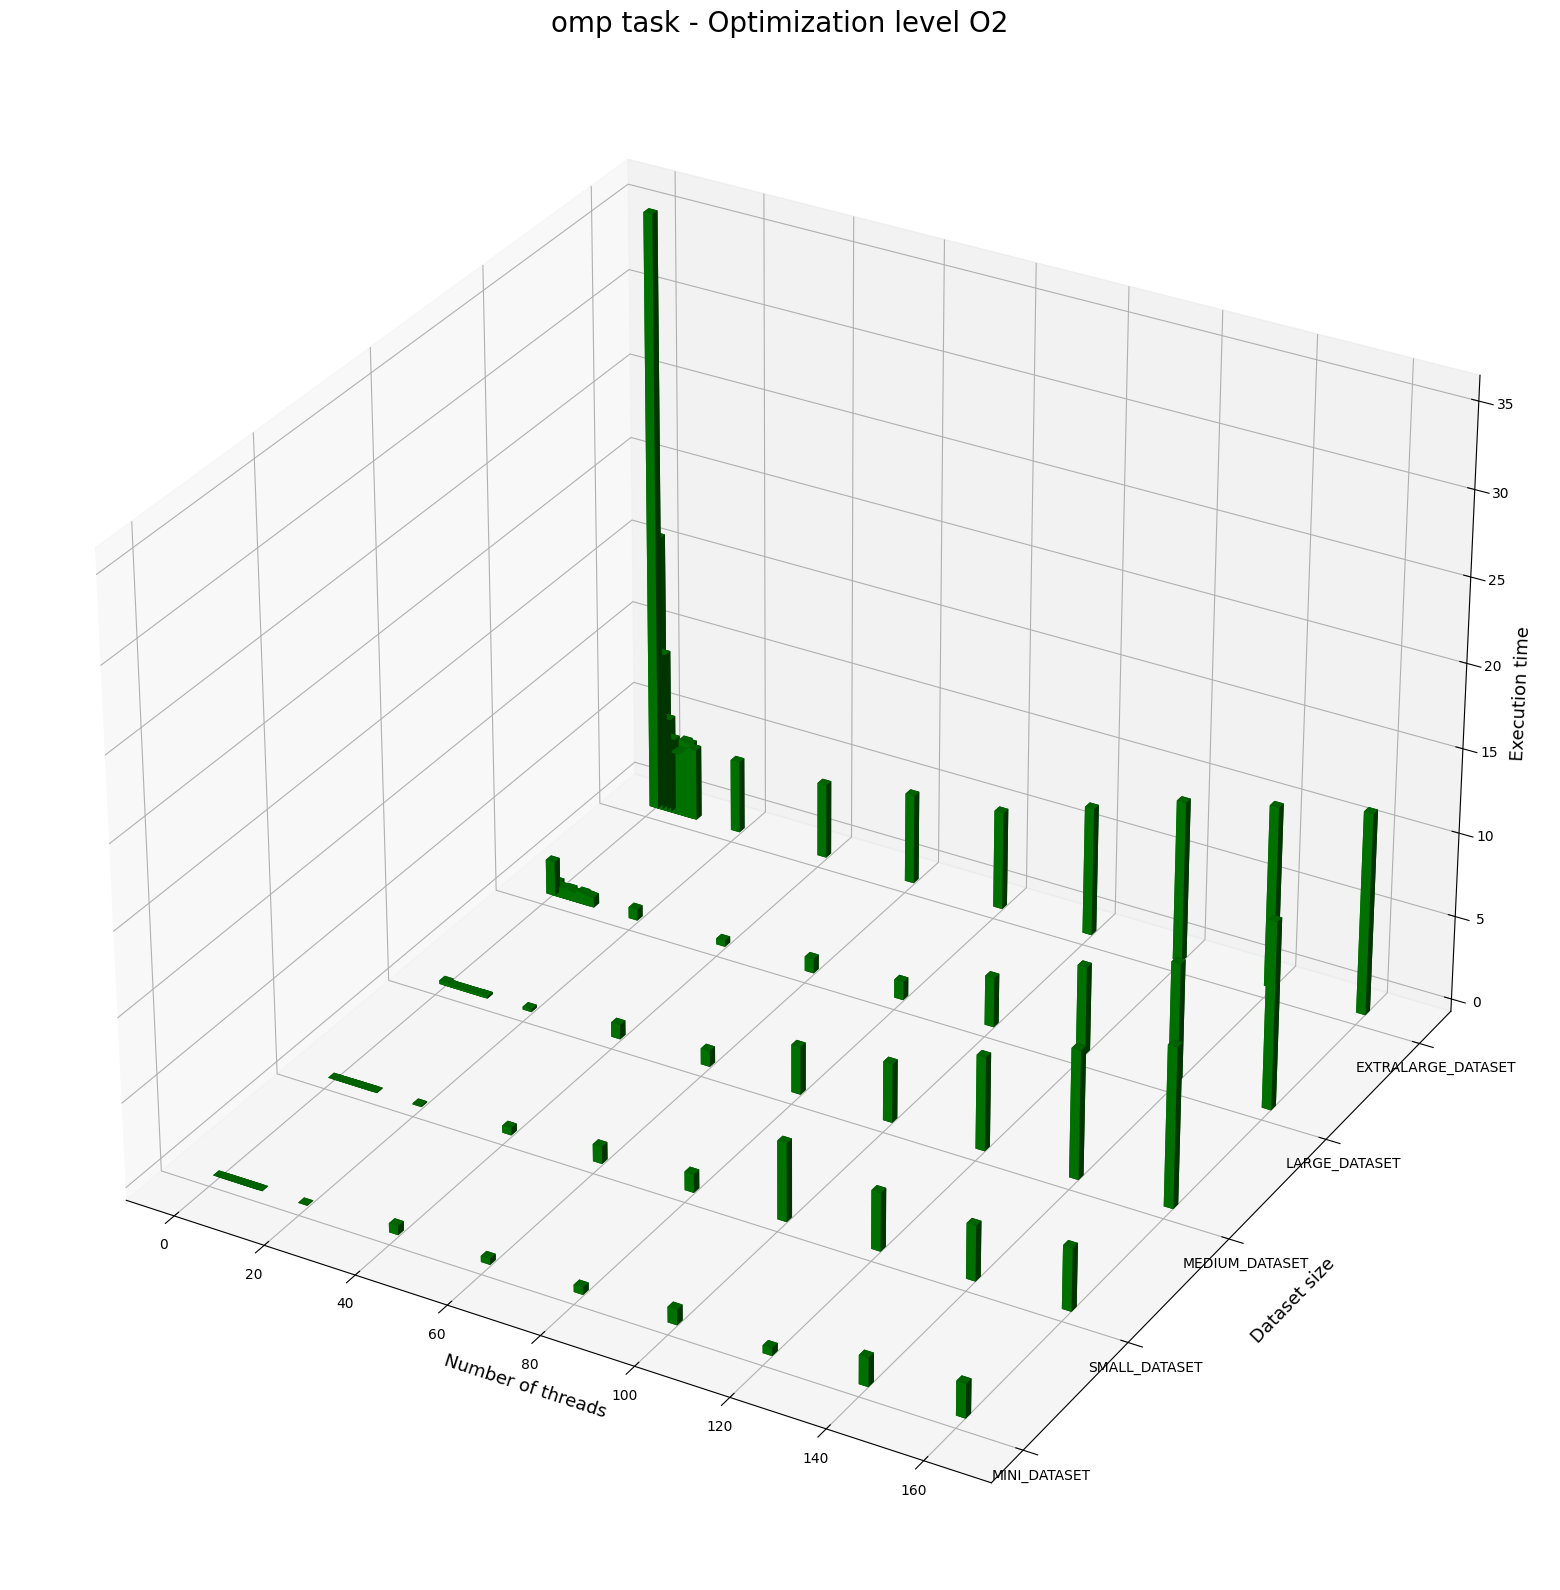

C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


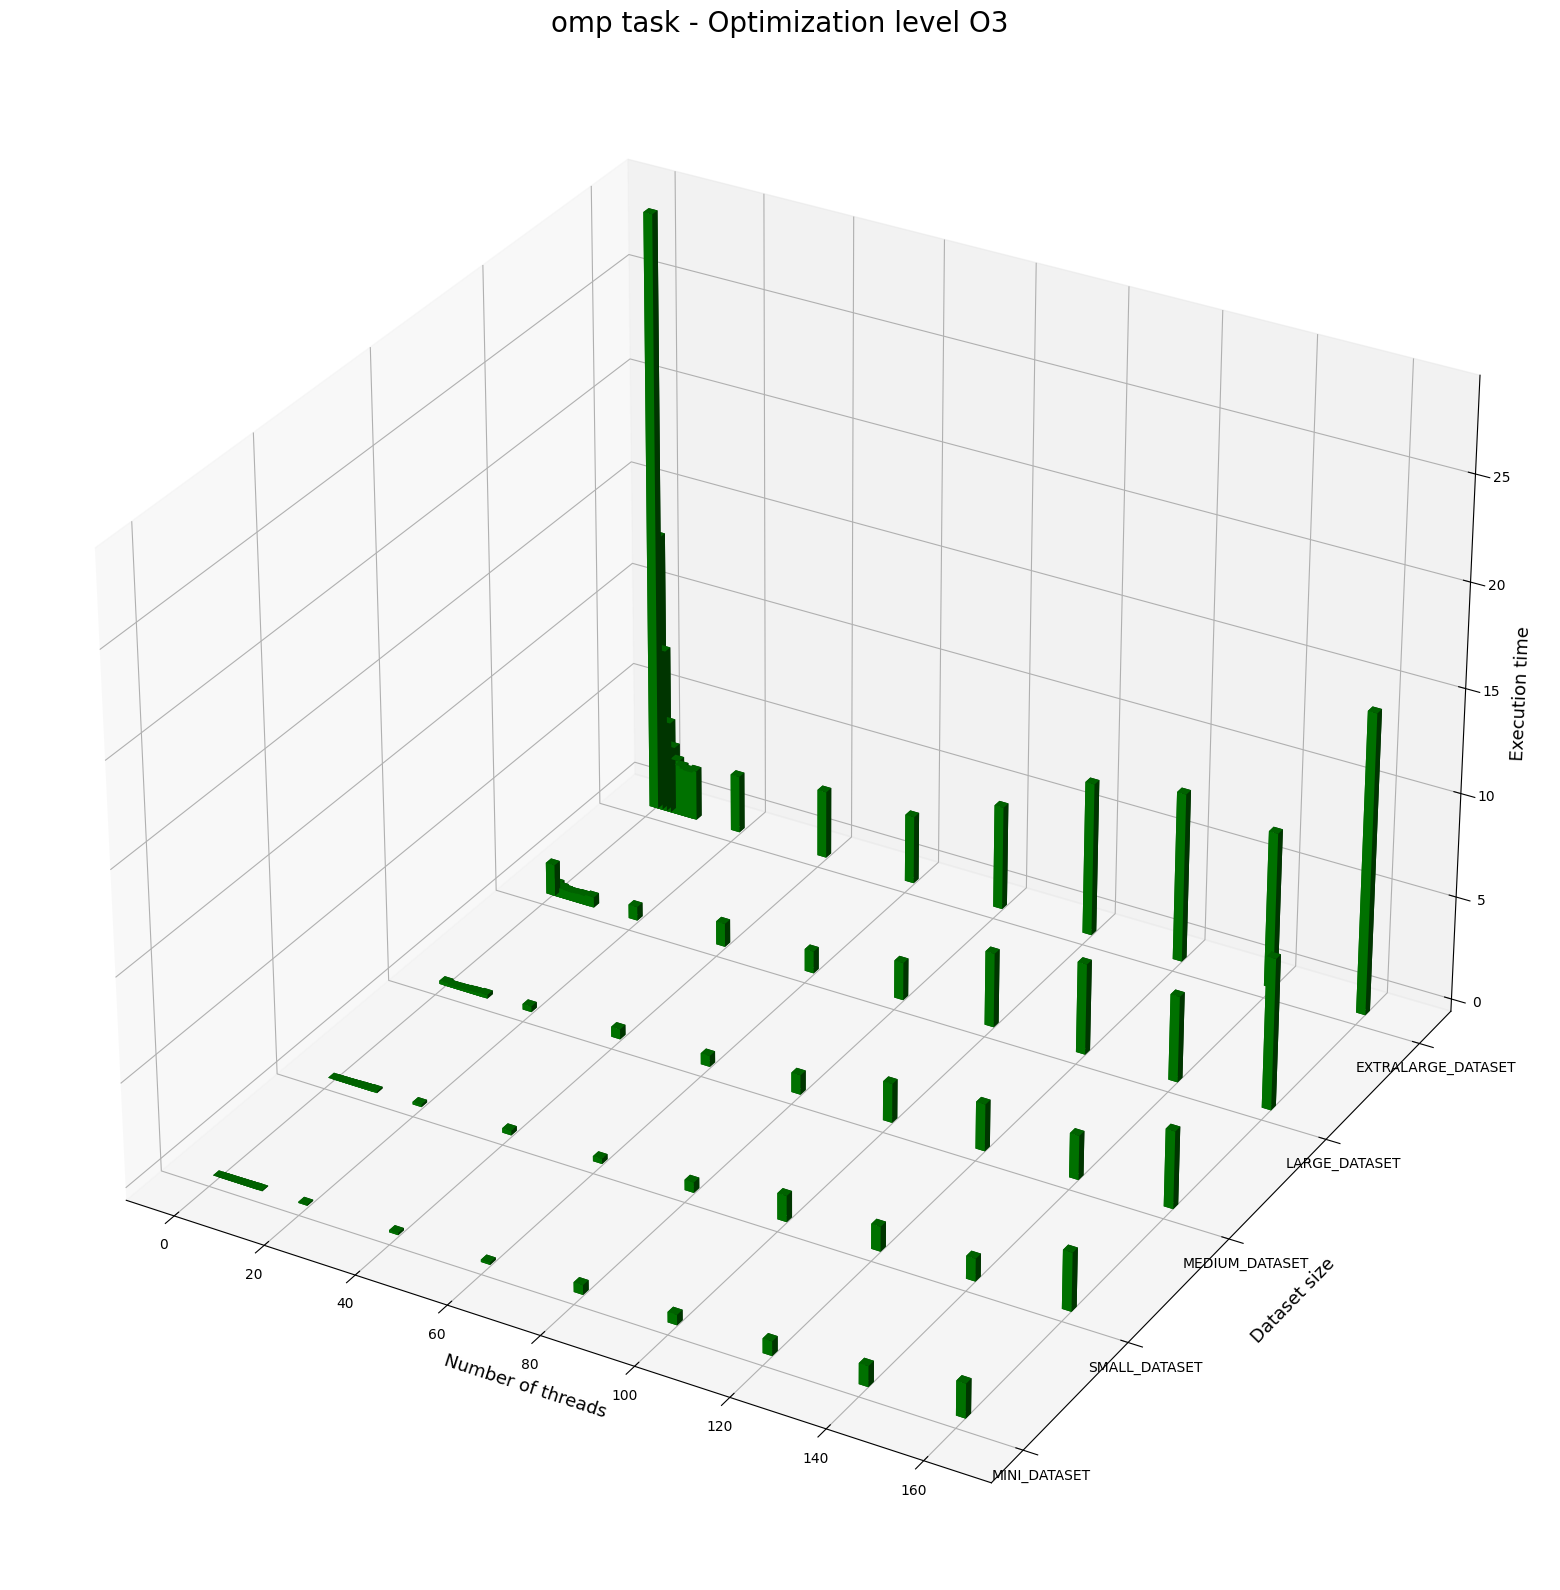

C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


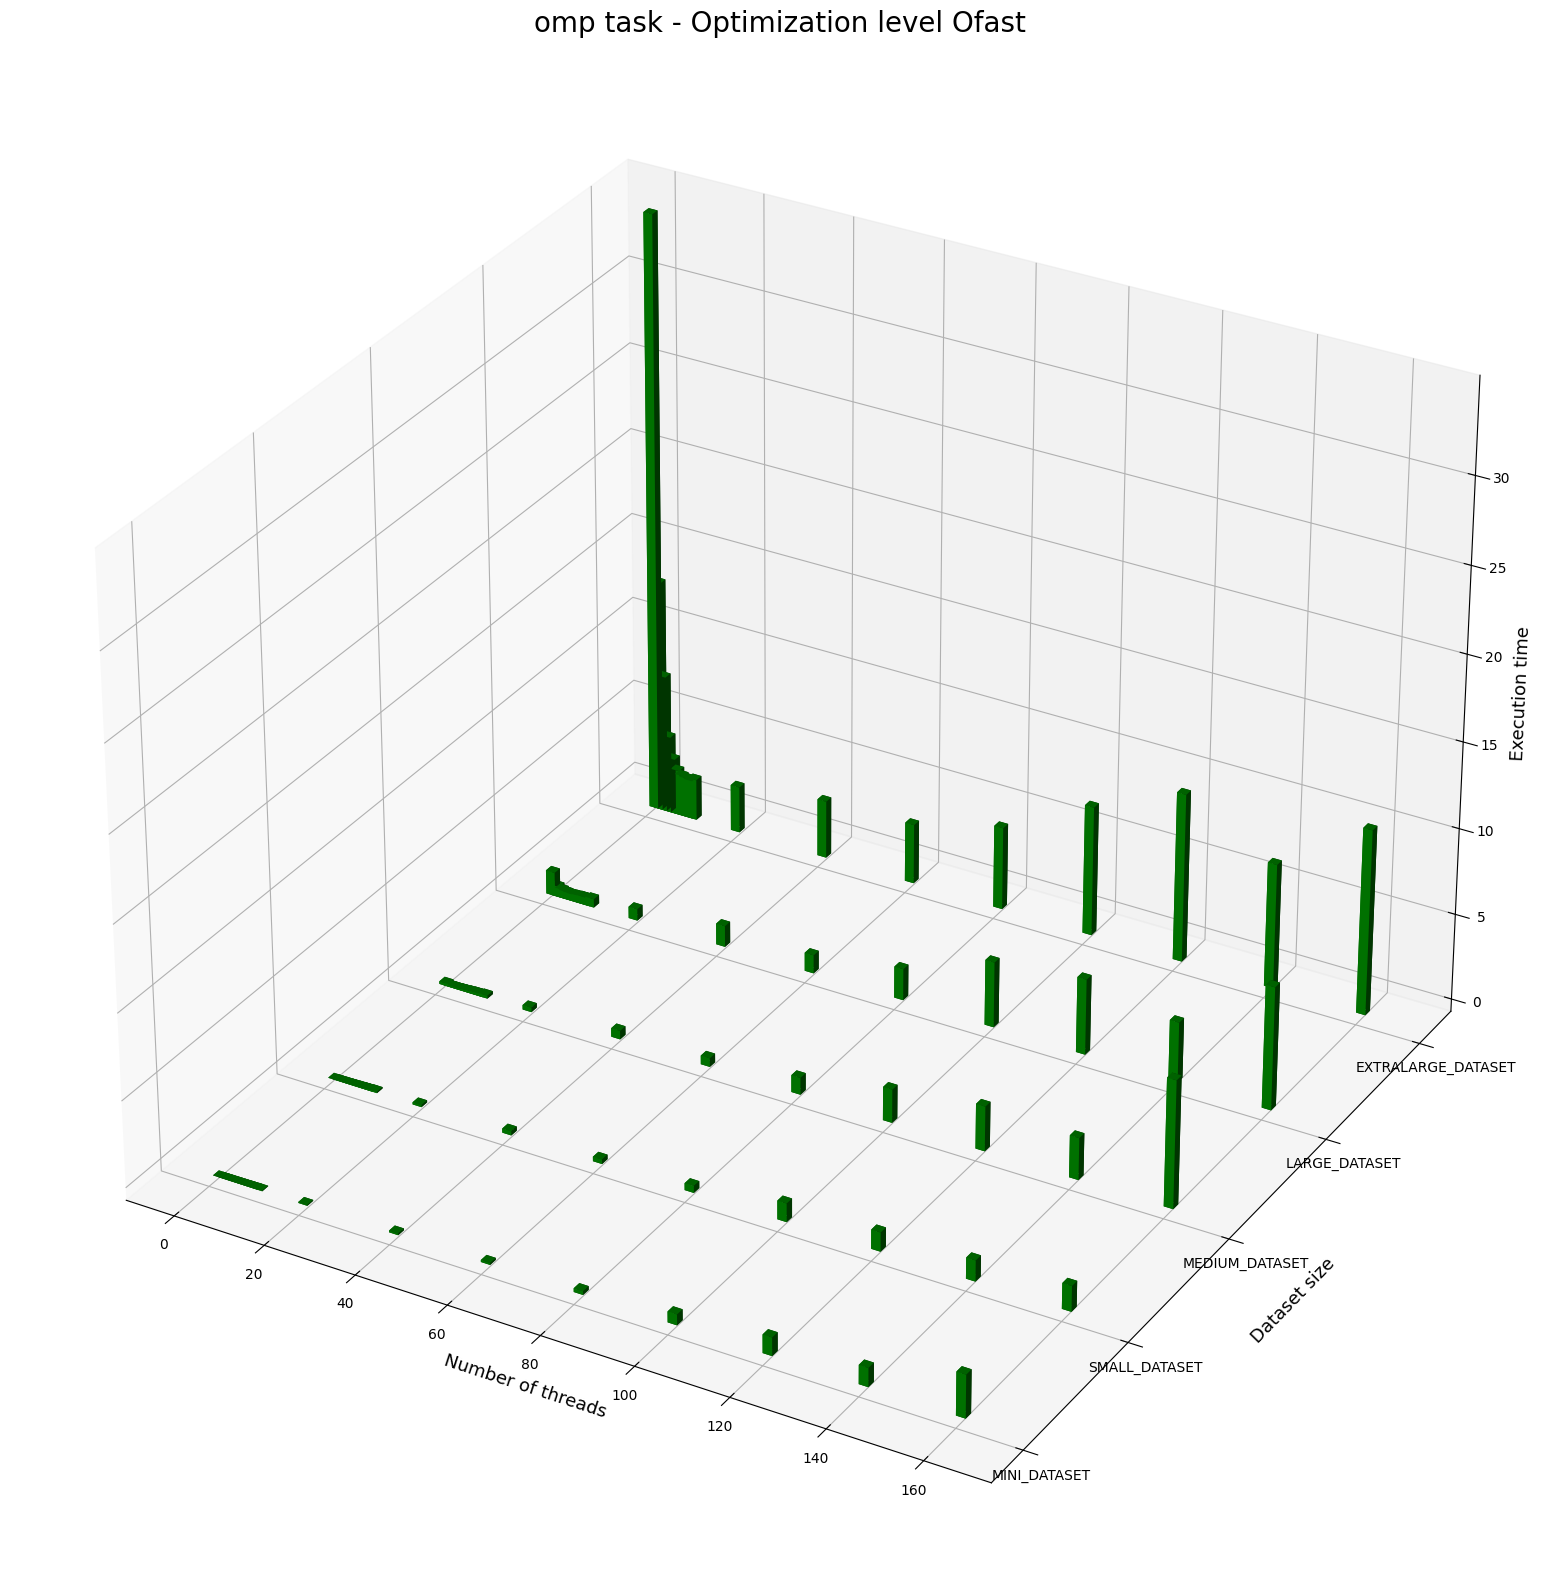

In [41]:
display_stats('task.txt', 'omp task')

## Оптимизация с помощью MPI
Изначально для реализации была выбрана неверная стратегия: Я копировал всю матрицу между процессами и вычислял её по блокам с синхронизацией в виде `MPI_Bcast`. После справедливых замечаний по коду, я усложнил алгоритм для корректного размещения в памяти.


### Описание обновленного алгоритма
Для наглядности я разделил функцию `relax` на две логические части: 


#### Проход по столбцам в relax_columns
В этой функции отведенная ей часть матрицы `A` разбивается на `columns_count` столбцов размера `N`. Для каждого столбца справедливо: `k` = `j`. Можно заметить, что элементы этих столбцов не лежат в памяти матрицы `A` подряд. Напротив, они разделены ровно `N * N` элементами между собой. Чтобы собрать эти разделенные части столбцов в единую сущность для распределения матрицы `A` по процессам, я обратился к функции `MPI_Type_vector`. Эта функция позволяет задать пользовательский тип вектор размера `m`, элементы которого будут взяты из некоторого массива с периодом `p`, заданном в этом типе. В нашем случае размер вектора будет `N`, а период `N * N`.
  
Так как матрица может не делиться на равное количество столбцов, для её распределения используется функция `MPI_Scatterv`, которая позволяет задать количество передаваемых элементов и расположение этих элементов относительно начала матрицы для каждого процесса. Симметрично ей, после вычислений, расположена функция `MPI_Gatherv`, которая собирает столбцы назад в изначальный массив. Значения для количества столбцов и отступа заранее считаются в функции `main` и передаются в `relax_columns`.

```c
int column_count = rank_column_count_map[proc_rank];
int size = column_count * N;

MPI_Scatterv(A, rank_column_count_map, rank_column_offset_map, MPI_FLOAT_COLUMN, columns_block, size, MPI_FLOAT, 0, MPI_COMM_WORLD);
for (int column_index = 0; column_index < column_count; column_index++) {
	for (int i = 2; i < N - 2; i++) {
		columns_block[N * column_index + i] = (
			columns_block[N * column_index + i - 2] +
			columns_block[N * column_index + i - 1] +
			columns_block[N * column_index + i + 1] +
			columns_block[N * column_index + i + 2]
		) * 0.25f;
	}
}
MPI_Gatherv(columns_block, size, MPI_FLOAT, A, rank_column_count_map, rank_column_offset_map, MPI_FLOAT_COLUMN, 0, MPI_COMM_WORLD);
```

#### Проход по плоскостям в relax_planes
Так как нашему алгоритму осталось пройтись по остальным двум координатам, было решено разделить матрицу сразу на плоскости, так как здесь уже спокойно можно итерировать по координате `i`, не боясь зависимости по данным. Заметим, что матрица, разделенная на `m` плоскостей удобно занимает непрерывную область памяти, что позволяет нам более не прибегать к векторизации данных. 

Матрица все еще может не делиться на равное количество плоскостей, так что, как и в предыдущем случае, функция `main` любезно подготовила нам количества элементов матрицы `A` для передачи через `MPI_Scatterv` для каждого процесса, а так же их смещения относительно `A`. Передачу и сбор данных в этой функции достаточно проделать один раз, так как процессы обрабатывают свои блоки вдоль двух координат независимо.

В последнем проходе по матрице считается `local_eps`, которая затем должна быть редуцирована по всем процессам. Для этого я использую функцию `MPI_Allreduce`, которая берет локальную `local_eps`, берет максимум по всем процессам и помешает результат в `eps` для возврата значения из функции.

```c
float eps = 0.f, local_eps = 0.f;

int size = rank_plane_count_map[proc_rank];
int plane_count = size / (N * N);

MPI_Scatterv(A, rank_plane_count_map, rank_plane_offset_map, MPI_FLOAT, planes_block, size, MPI_FLOAT, 0, MPI_COMM_WORLD);
for (int i = 0; i < plane_count; i++) {
	for (int j = 2; j < N - 2; j++) {
		for (int k = 0; k < N; k++) {
			planes_block[IND(i, j, k)] = (
				planes_block[IND(i, j - 1, k)] +
				planes_block[IND(i, j - 2, k)] +
				planes_block[IND(i, j + 1, k)] +
				planes_block[IND(i, j + 2, k)]
			) * 0.25f;
		}
	}
}

for (int i = 0; i < plane_count; i++) {
	for (int j = 0; j < N; j++) {
		for (int k = 2; k < N - 2; k++) {
			float e = planes_block[IND(i, j, k)];
			planes_block[IND(i, j, k)] = (
				planes_block[IND(i, j, k - 1)] +
				planes_block[IND(i, j, k - 2)] +
				planes_block[IND(i, j, k + 1)] +
				planes_block[IND(i, j, k + 2)]
			) * 0.25f;
			local_eps = Max(local_eps, fabsf(e - planes_block[IND(i, j, k)]));
		}
	}
}
MPI_Gatherv(planes_block, size, MPI_FLOAT, A, rank_plane_count_map, rank_plane_offset_map, MPI_FLOAT, 0, MPI_COMM_WORLD);
MPI_Reduce(&local_eps, &eps, 1, MPI_FLOAT, MPI_MAX, 0, MPI_COMM_WORLD);
MPI_Bcast(&eps, 1, MPI_FLOAT, 0, MPI_COMM_WORLD);

return eps;
```
  
Посмотрим на результаты измерений времени исполнения:    

C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


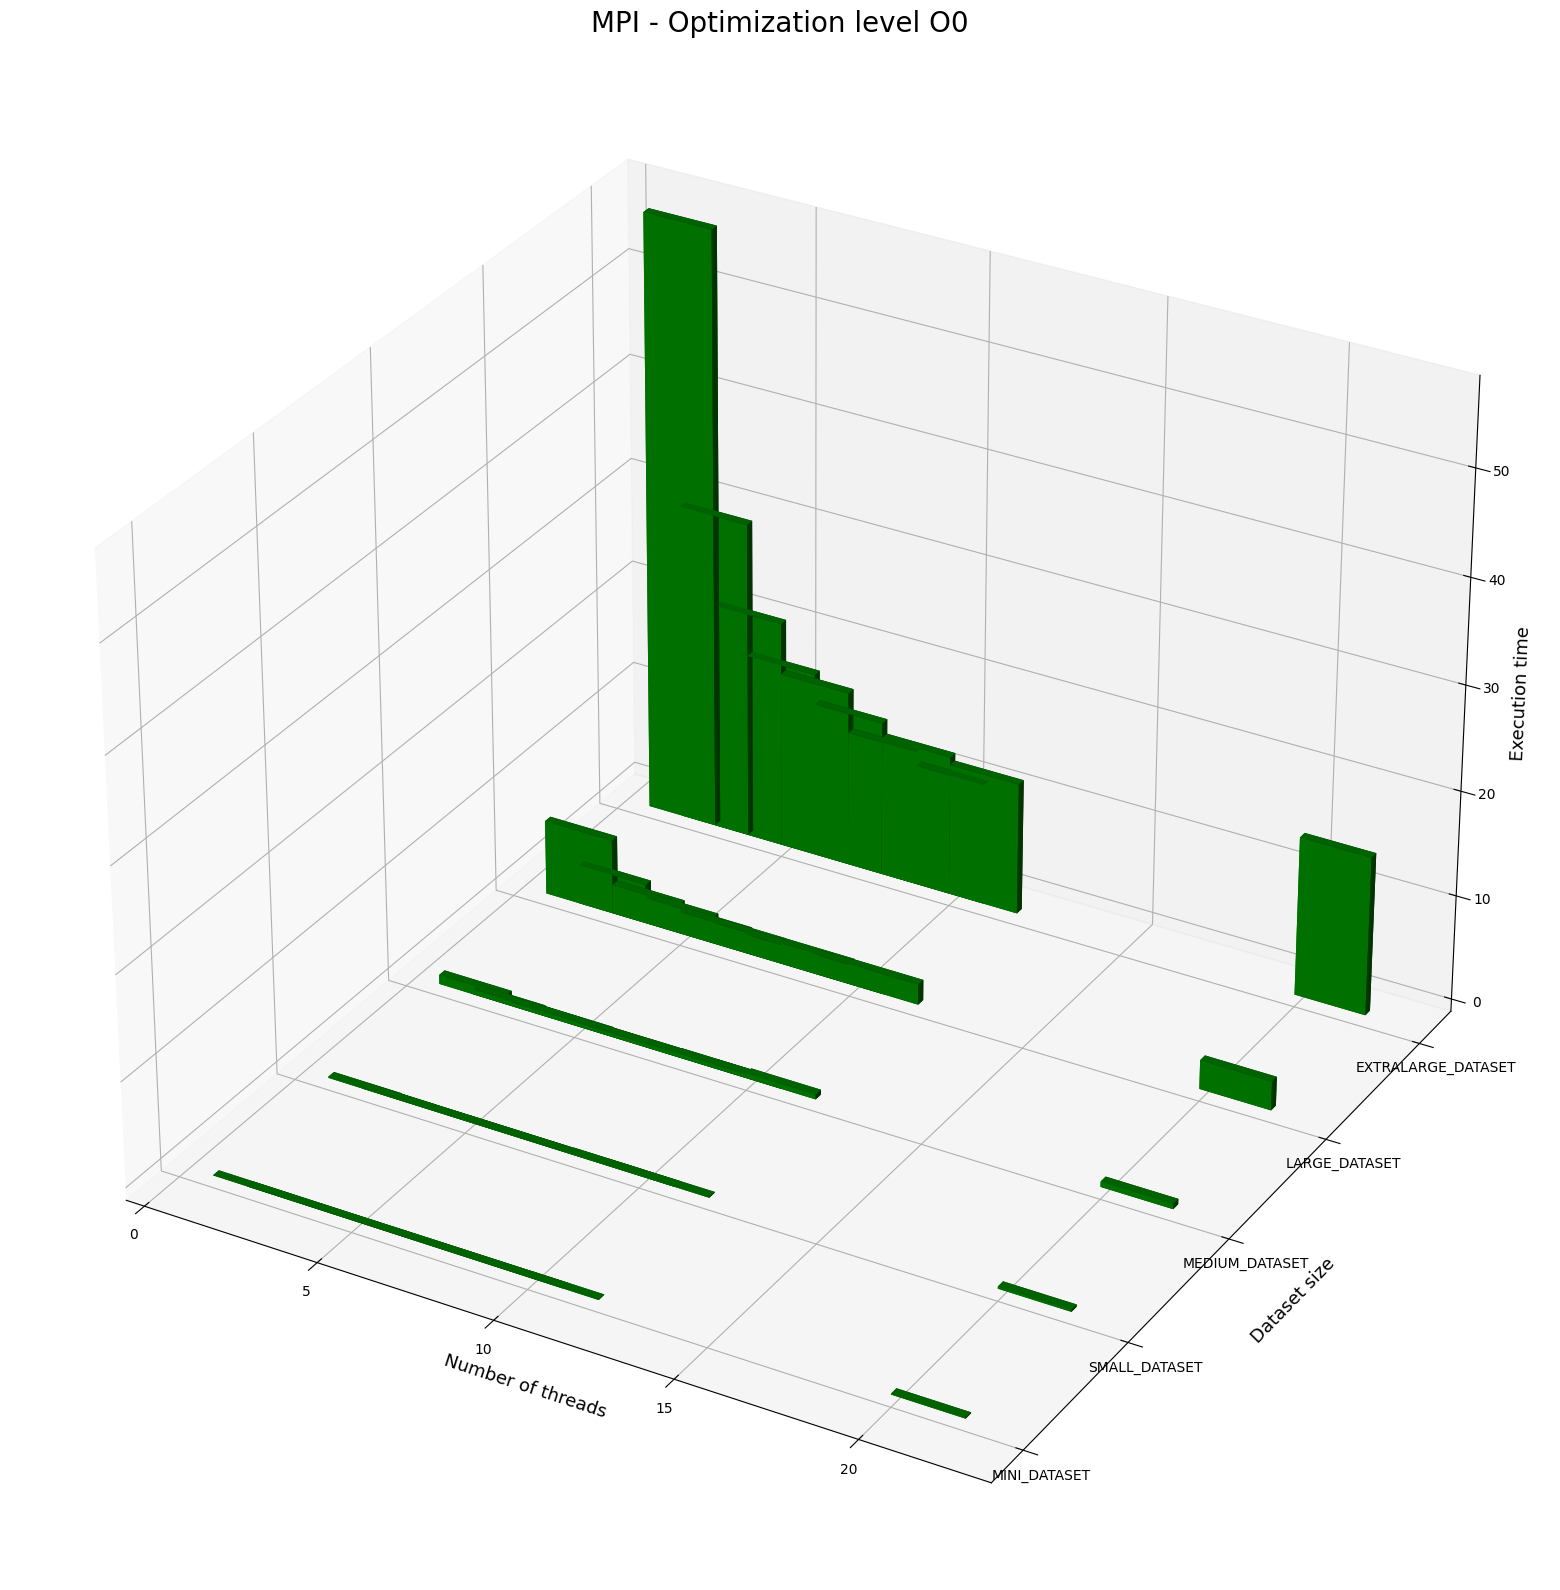

C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


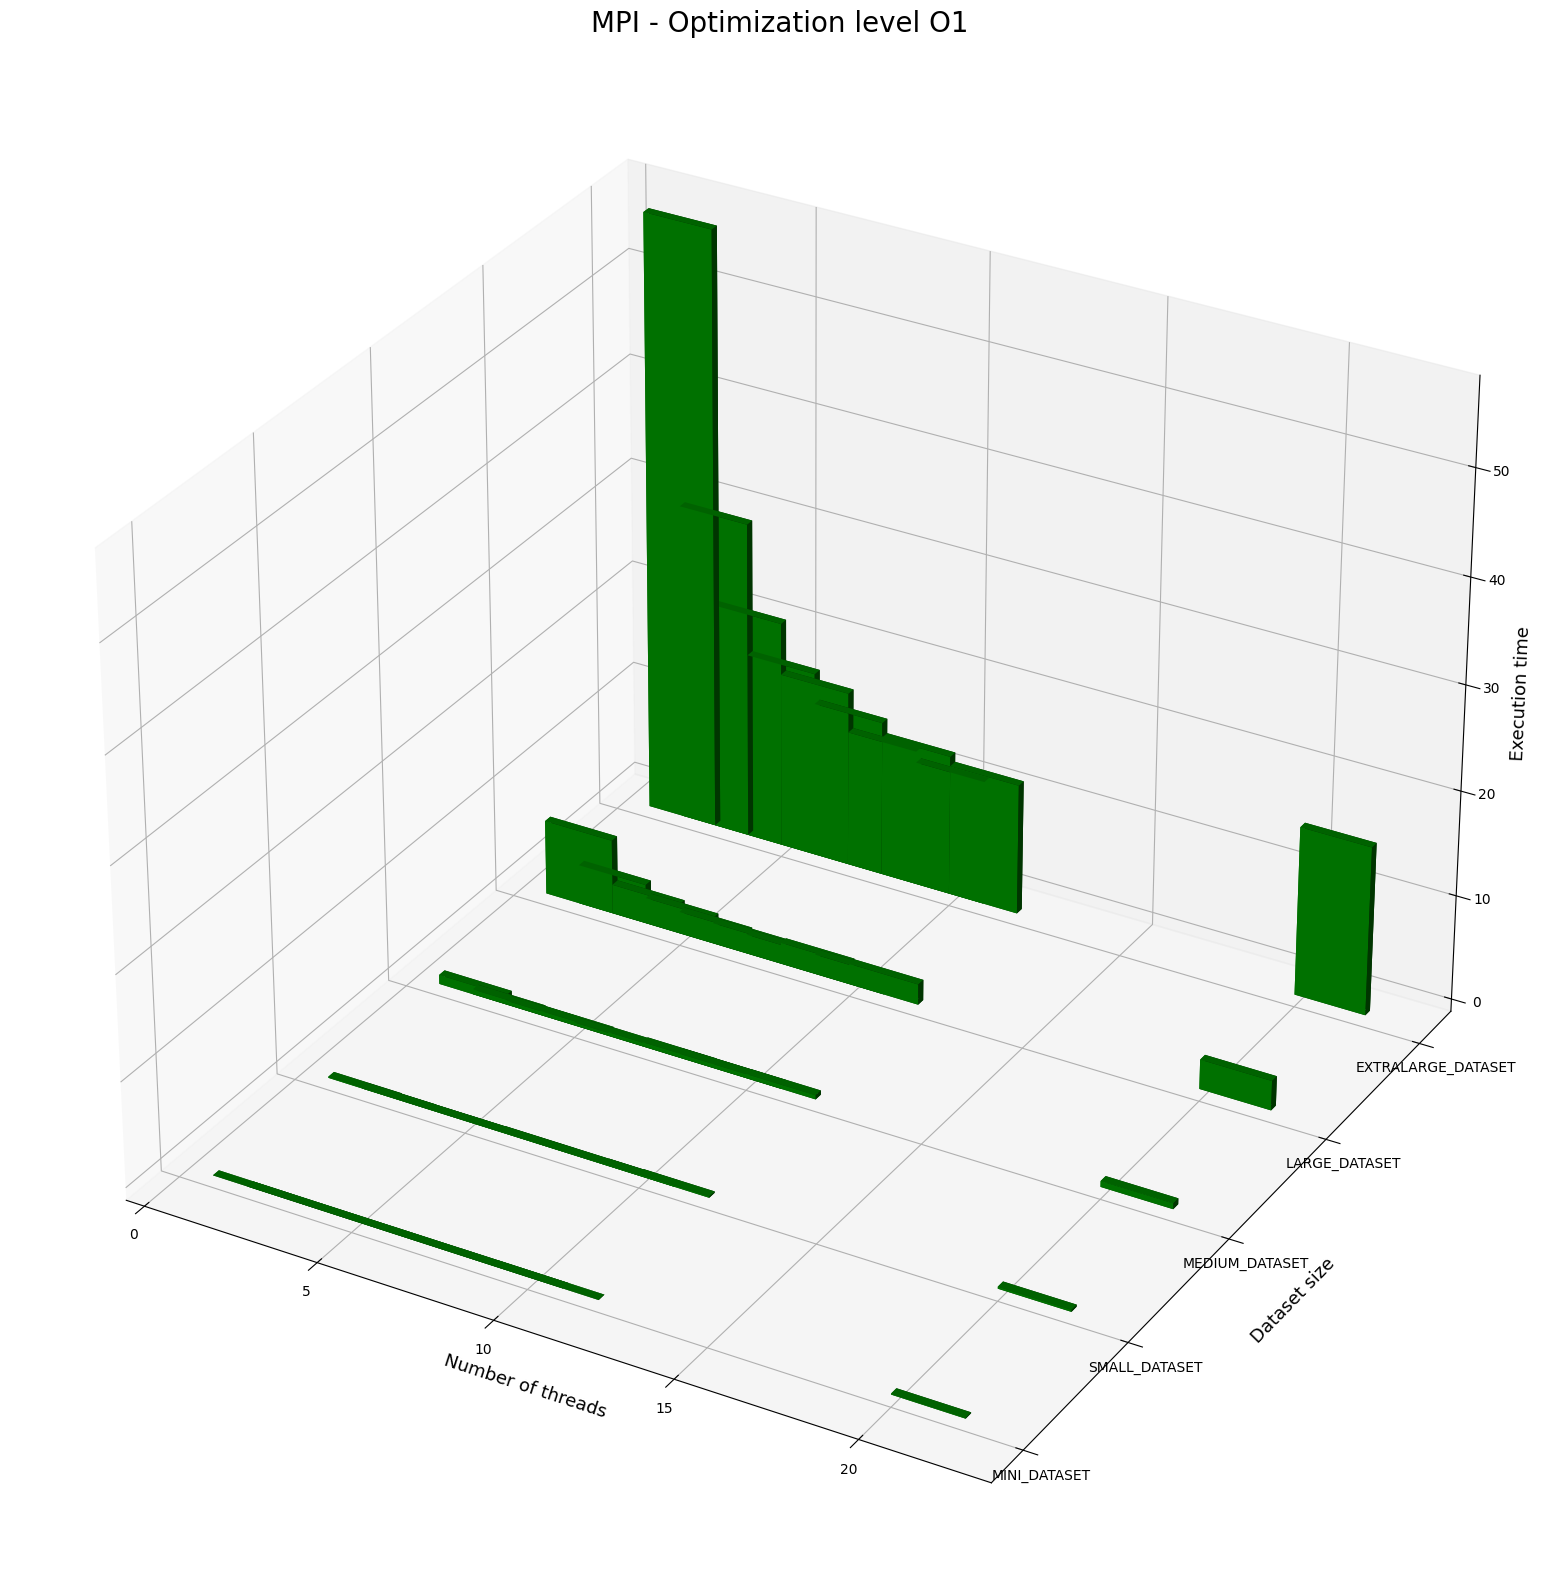

C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


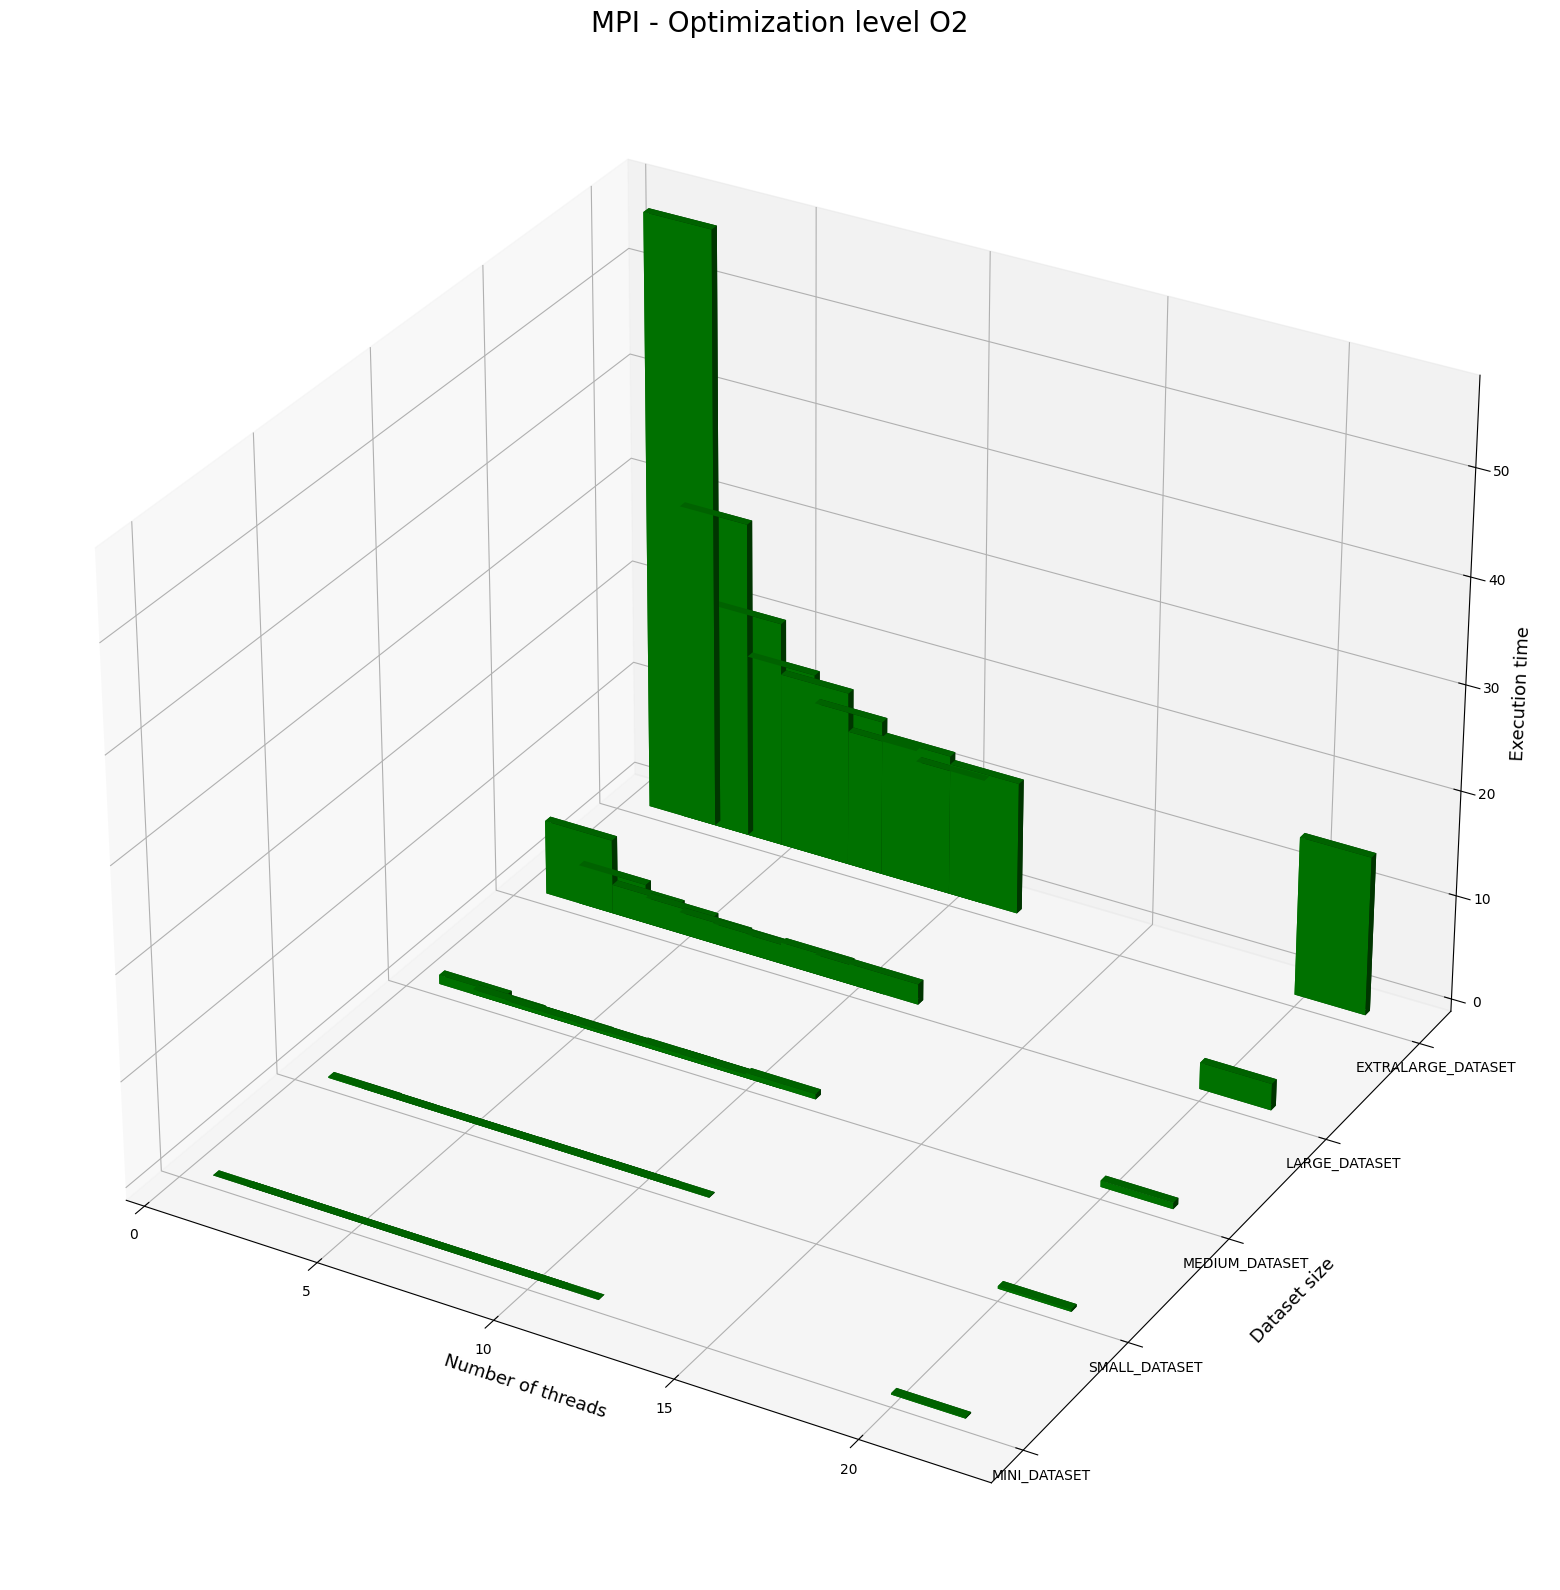

C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


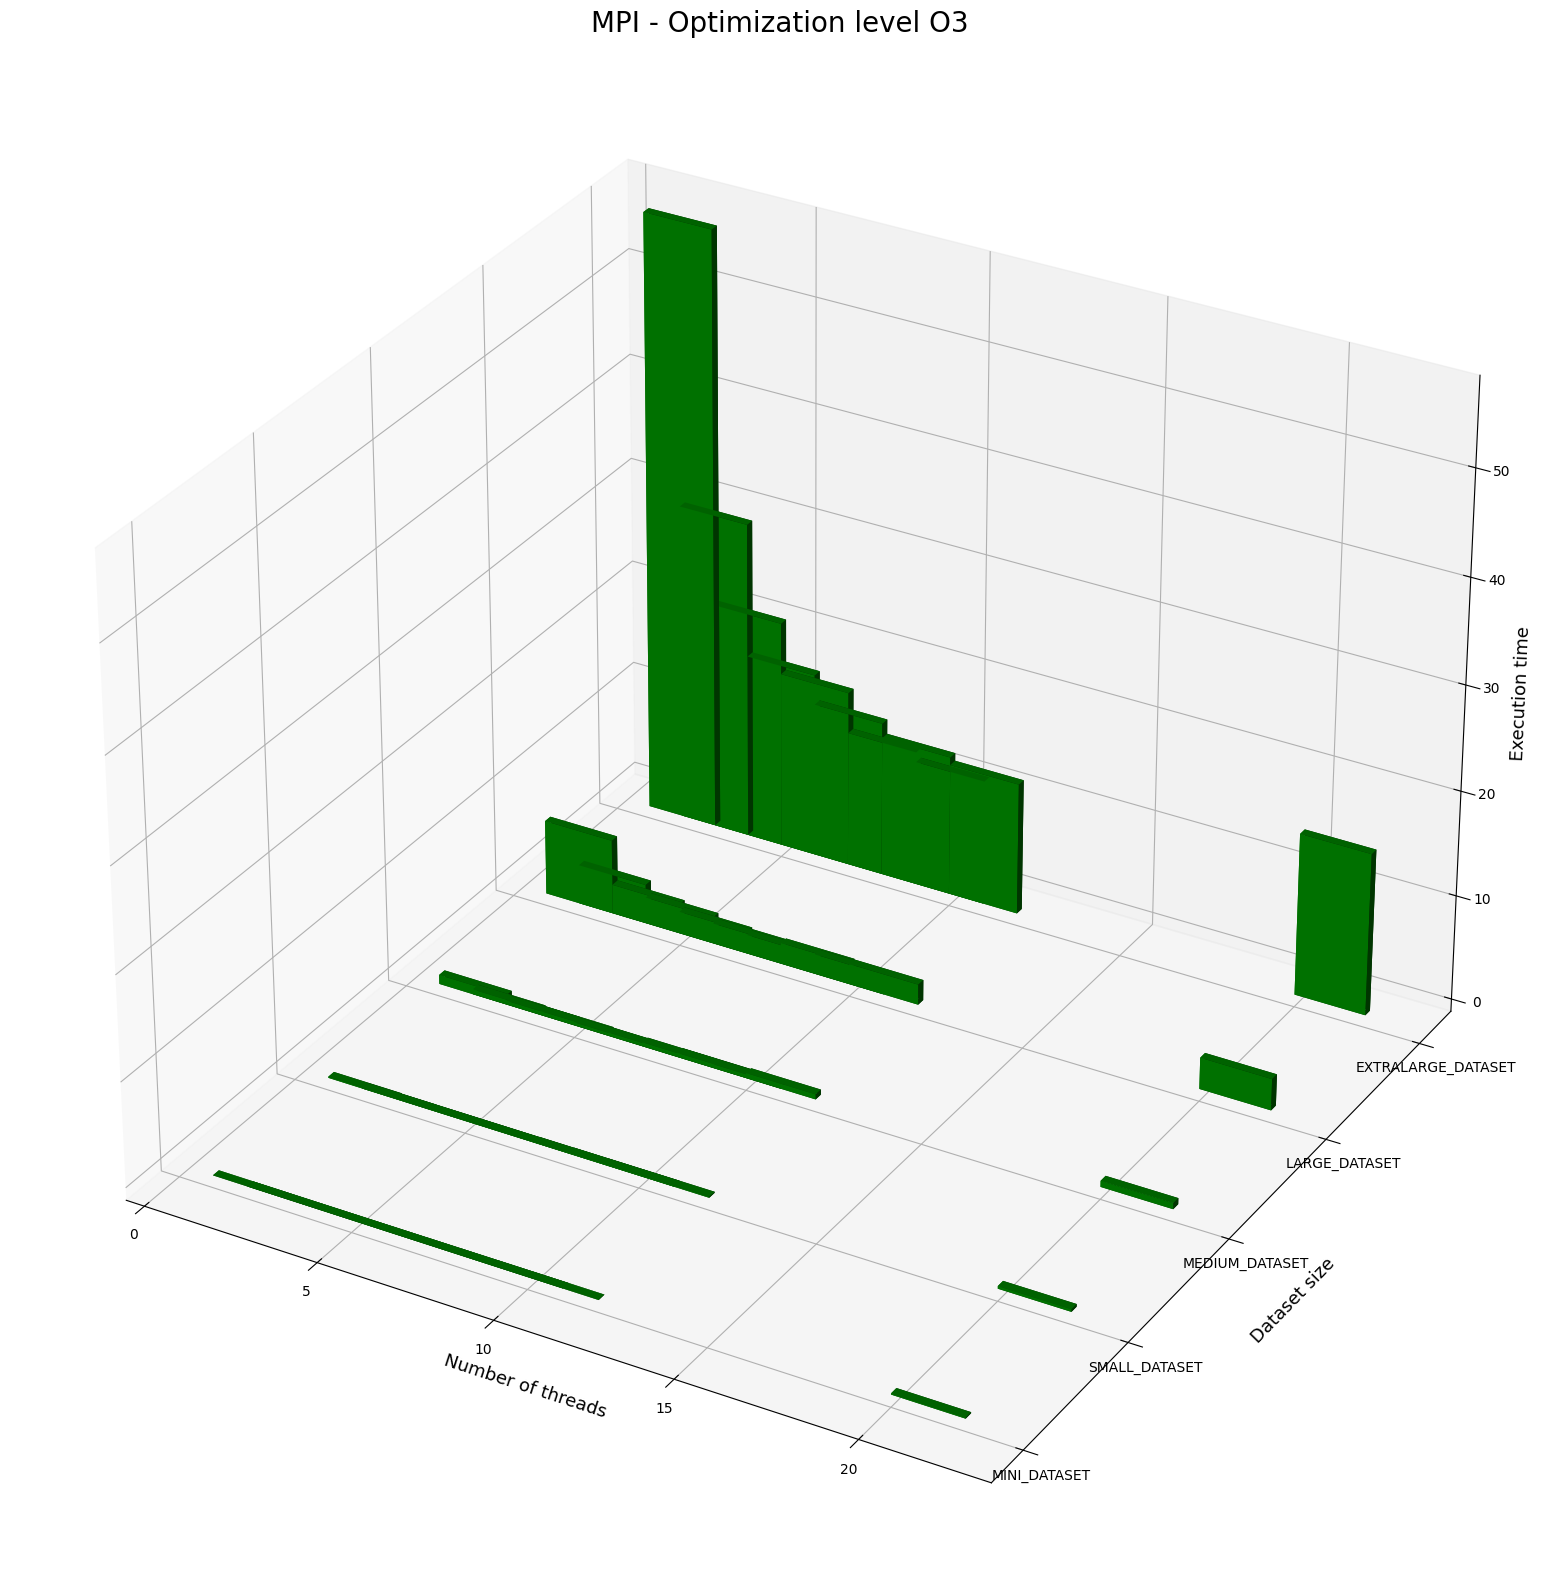

C:\Users\chere\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


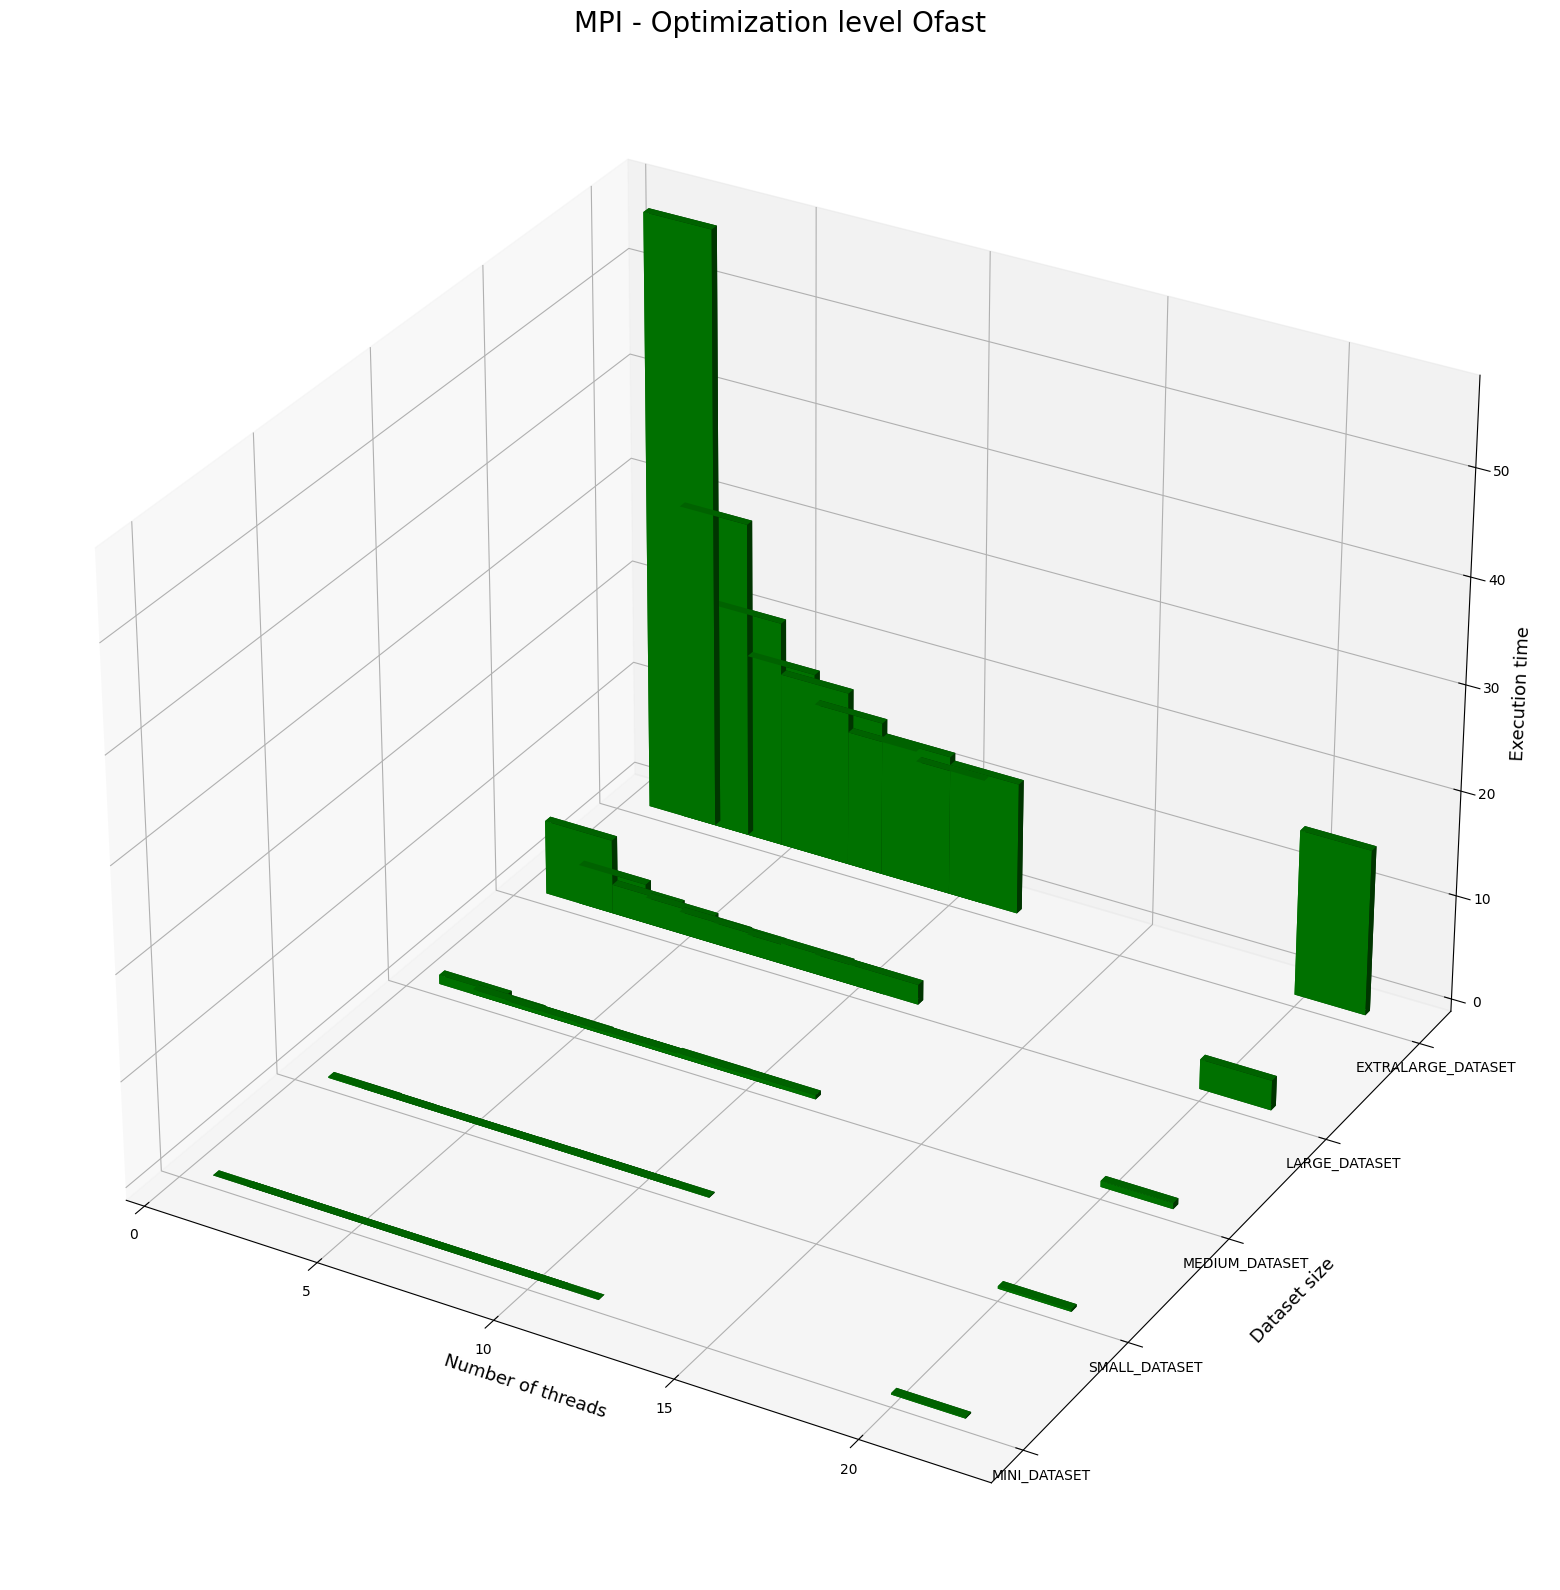

In [42]:
display_stats('mpi.txt', 'MPI')

# Выводы:
Можно заметить, что с увеличением числа потоков идет снижение времени выполнения, однако, приближаясь к максимальному числу потоков, время выполнения может увеличиться.

Это происходит по нескольким причинам:
1. Ввиду ограниченного количества арифметических блоков на вычислителе, с ростом числа потоков растет и нагрузка на эти блоки, следовательно, растет и время исполнения.
2. В моем случае, вероятнее всего, происходит большое число промахов в кэше связанное с моими перестановками порядка индексации во избежание гонки за данными. Чем больше потоков, тем больше обращений к памяти, и, следовательно, больше промахов в кэше.

Также, можно заметить, что во всех случаях уровень оптимизации компилятора значительно улучшает результаты как в однопоточном исполнении, так и в многопоточном.